<a href="https://colab.research.google.com/github/danadler-dev/JTB---SDSA-Paper/blob/main/SDA_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Custom Stability vs Unconstrained Comparison
# Simplified implementation for direct comparison with original code

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter, defaultdict
from tqdm.notebook import tqdm

# PatternInstance class for tracking pattern lifetimes
class PatternInstance:
    def __init__(self, pattern, creation_time, expiration_time):
        self.pattern = pattern
        self.creation_time = creation_time
        self.expiration_time = expiration_time

    def is_expired(self, current_time):
        return current_time >= self.expiration_time

def run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # None for unconstrained, dict for custom stability
    replenishment_rate=5,
    interactions_per_gen=50,
    generations=100,
    selection_mode="frequency_proportional",  # "uniform" or "frequency_proportional"
    name="Simulation",
    init_pop=None,
    init_hist=None,
    seed=42
):
    """Run a simulation with given parameters."""
    # Set random seed
    random.seed(seed)
    np.random.seed(seed)

    # Initialize
    population = [] if init_pop is None else init_pop

    # Default stability function (all patterns have stability 1)
    if stability is None:
        stability_function = lambda pattern: 1
        name = "Unconstrained System"
    else:
        # Custom stability function using provided dictionary
        def stability_function(pattern):
            return stability.get(pattern, 1)  # Default to 1 if not specified
        name = "Custom Stability System"

    # Add initial base elements
    if init_pop is None:
      for element in base_elements:
          element_stability = stability_function(element)
          for _ in range(replenishment_rate):
              population.append(PatternInstance(element, 0, element_stability))
    else:
      for p in population:
          #if a prior population was passed in - reset its expiration relative to now
          p.expiration_time -= p.creation_time

    # Track history
    history = {} if init_hist is None else init_hist
    history['populations'] = []
    history['entropy'] = []
    history['total_counts'] = []
    history['pattern_counts'] = []

    # Run simulation
    for t in tqdm(range(1, generations + 1), desc=name):
        # 1. Remove expired patterns
        population = [p for p in population if not p.is_expired(t)]

        # 2. Replenish base elements
        for element in base_elements:
            element_stability = stability_function(element)
            for _ in range(replenishment_rate):
                population.append(PatternInstance(element, t, t + element_stability))

        # 3. Perform interactions
        if population and len(population) >= 2:
            # Get current pattern distribution for selection
            pattern_types = [p.pattern for p in population]
            pattern_counts = Counter(pattern_types)

            for _ in range(interactions_per_gen):
                # Select patterns based on selection mode
                if selection_mode == "frequency_proportional":
                    # Select patterns based on their frequency
                    selected_patterns = random.choices(
                        list(pattern_counts.keys()),
                        weights=[pattern_counts[p] for p in pattern_counts],
                        k=2
                    )

                    # Find instances of those patterns
                    p1_pattern, p2_pattern = selected_patterns
                    p1_instances = [p for p in population if p.pattern == p1_pattern]
                    p2_instances = [p for p in population if p.pattern == p2_pattern]

                    # Select random instances
                    p1 = random.choice(p1_instances)
                    if p1_pattern == p2_pattern and len(p1_instances) > 1:
                        p2_instances.remove(p1)
                    p2 = random.choice(p2_instances)
                else:
                    # Uniform selection (random)
                    p1, p2 = random.sample(population, 2)

                # Form new pattern
                new_pattern = p1.pattern + p2.pattern

                # Skip if too long
                if len(new_pattern) > 50:
                    continue

                # Add new pattern with stability
                new_stability = stability_function(new_pattern)
                population.append(PatternInstance(new_pattern, t, t + new_stability))

        # 4. Record state
        pattern_counts = Counter(p.pattern for p in population)
        total_count = len(population)

        # Calculate entropy
        if total_count > 0:
            probs = [count / total_count for count in pattern_counts.values()]
            entropy = -sum(p * np.log2(p) for p in probs if p > 0)
        else:
            entropy = 0

        # Store metrics
        history['entropy'].append(entropy)
        history['pattern_counts'].append(len(pattern_counts))
        history['total_counts'].append(total_count)
        history['populations'].append(dict(pattern_counts))

    # Return results
    return {
        'name': name,
        'history': history,
        'final_population': dict(Counter(p.pattern for p in population)),
        'final_raw_population': population  # Include raw population data for analysis
    }

def compare_simulations(results_list):
    """Create comparison visualizations between simulations."""
    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Entropy comparison
    for result in results_list:
        axs[0, 0].plot(result['history']['entropy'], label=result['name'], linewidth=2)

    axs[0, 0].set_xlabel('Generation')
    axs[0, 0].set_ylabel('Shannon Entropy')
    axs[0, 0].set_title('Entropy Comparison')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # 2. Pattern counts
    for result in results_list:
        axs[0, 1].plot(result['history']['pattern_counts'], label=result['name'], linewidth=2)

    axs[0, 1].set_xlabel('Generation')
    axs[0, 1].set_ylabel('Unique Pattern Count')
    axs[0, 1].set_title('Pattern Diversity')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 3. Top patterns in first simulation
    if results_list and 'final_population' in results_list[0]:
        top_patterns = sorted(results_list[0]['final_population'].items(), key=lambda x: x[1], reverse=True)[:8]
        if top_patterns:
            patterns, counts = zip(*top_patterns)
            display_patterns = [p[:8] + ('...' if len(p) > 8 else '') for p in patterns]

            bars = axs[1, 0].bar(range(len(display_patterns)), counts, color='skyblue')
            axs[1, 0].set_xticks(range(len(display_patterns)))
            axs[1, 0].set_xticklabels(display_patterns, rotation=45, ha='right')
            axs[1, 0].set_xlabel('Pattern')
            axs[1, 0].set_ylabel('Count')
            axs[1, 0].set_title(f'Top Patterns ({results_list[0]["name"]})')

            # Add percentage labels
            total = sum(counts)
            for i, bar in enumerate(bars):
                height = bar.get_height()
                percentage = (counts[i] / total * 100) if total > 0 else 0
                axs[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                             f"{percentage:.1f}%", ha='center', va='bottom', rotation=0)

    # 4. Top patterns in second simulation
    if len(results_list) > 1 and 'final_population' in results_list[1]:
        top_patterns = sorted(results_list[1]['final_population'].items(), key=lambda x: x[1], reverse=True)[:8]
        if top_patterns:
            patterns, counts = zip(*top_patterns)
            display_patterns = [p[:8] + ('...' if len(p) > 8 else '') for p in patterns]

            # Use different color scheme for custom stability system
            bar_colors = plt.cm.viridis(np.linspace(0, 1, len(display_patterns)))

            bars = axs[1, 1].bar(range(len(display_patterns)), counts, color=bar_colors)
            axs[1, 1].set_xticks(range(len(display_patterns)))
            axs[1, 1].set_xticklabels(display_patterns, rotation=45, ha='right')
            axs[1, 1].set_xlabel('Pattern')
            axs[1, 1].set_ylabel('Count')
            axs[1, 1].set_title(f'Top Patterns ({results_list[1]["name"]})')

            # Add percentage labels
            total = sum(counts)
            for i, bar in enumerate(bars):
                height = bar.get_height()
                percentage = (counts[i] / total * 100) if total > 0 else 0
                axs[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                             f"{percentage:.1f}%", ha='center', va='bottom', rotation=0)

    plt.suptitle("Simulation Comparison", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    return fig


Running unconstrained simulation...


Unconstrained System:   0%|          | 0/600 [00:00<?, ?it/s]


Running custom stability simulation...


Custom Stability System:   0%|          | 0/600 [00:00<?, ?it/s]


Key Metrics:
Final entropy (Unconstrained): 6.3556
Final entropy (Custom Stability): 3.4847
Entropy reduction: 2.8709

Top patterns in Unconstrained system:
  A: 5 (4.35%)
  B: 5 (4.35%)
  C: 5 (4.35%)
  CA: 3 (2.61%)
  AA: 3 (2.61%)

Top patterns in Custom Stability system:
  ABCABA: 88 (37.77%)
  ABCABAABCABA: 42 (18.03%)
  B: 10 (4.29%)
  BC: 9 (3.86%)
  ABC: 9 (3.86%)


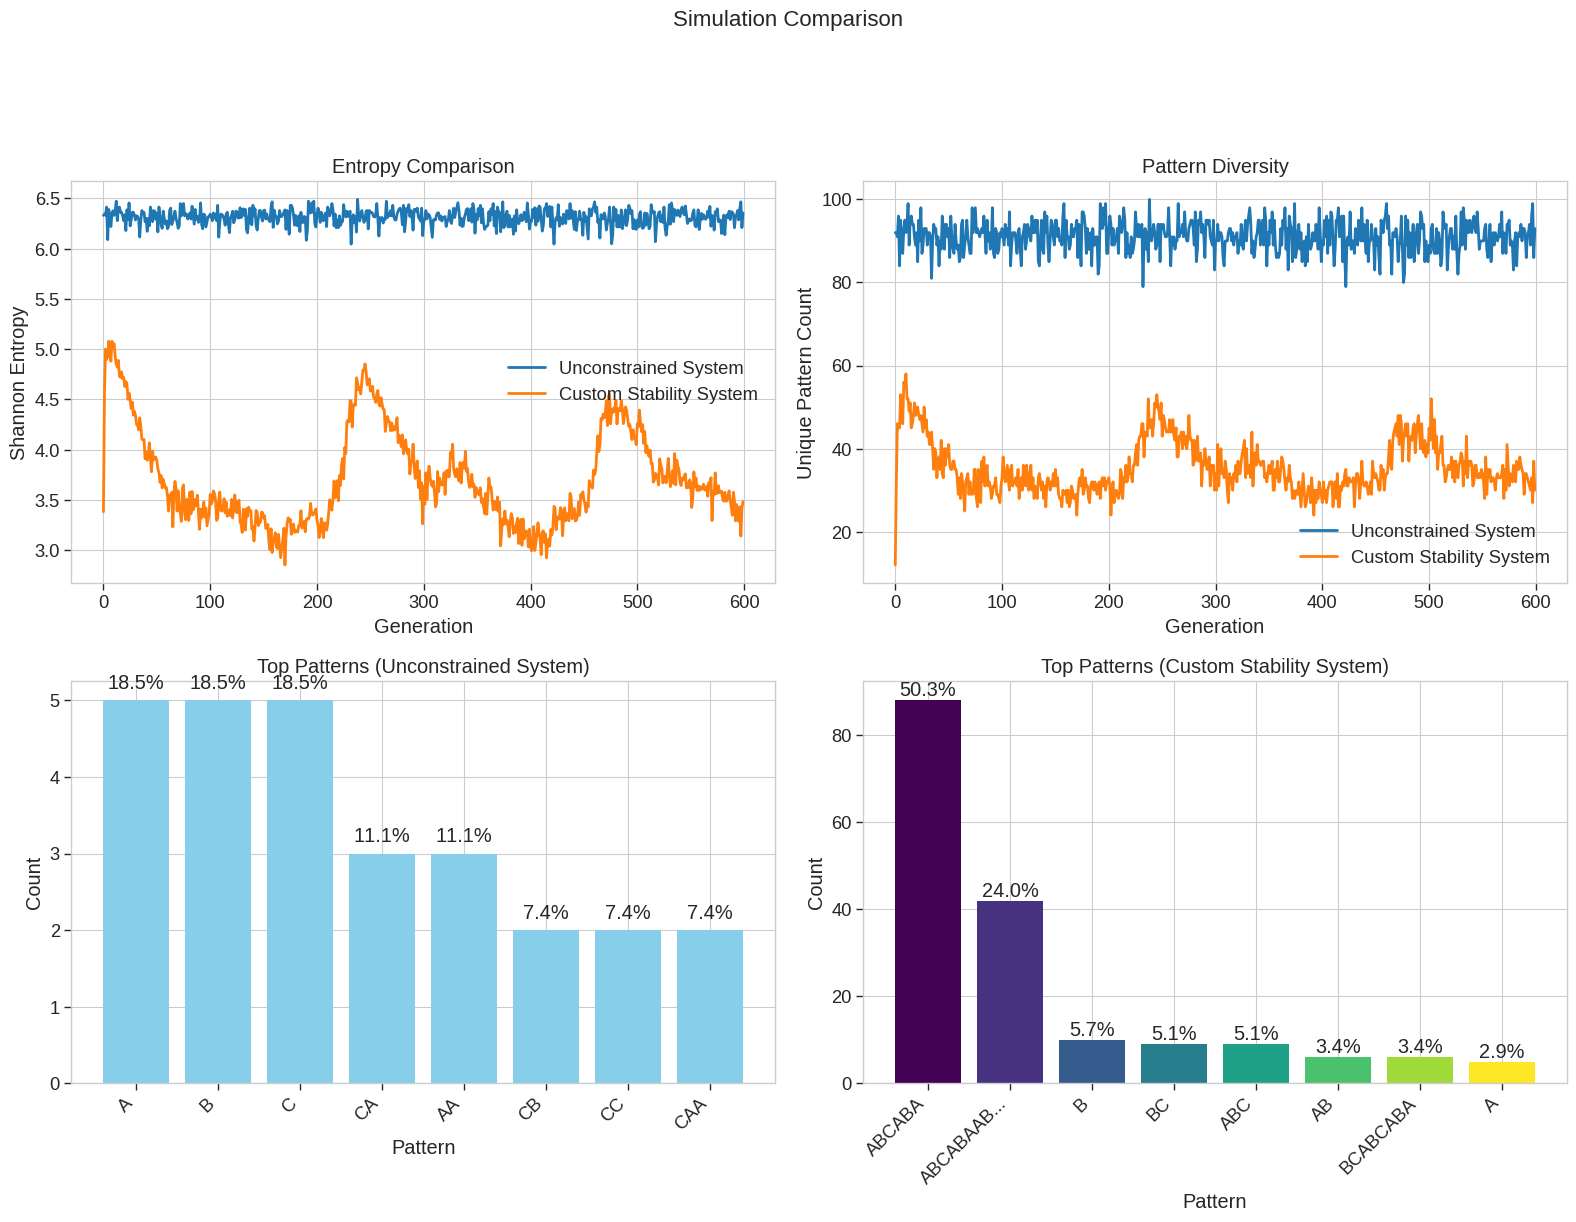

In [ ]:
# Simulation with one dominant pattern

custom_stability = {
    "AB": 30, "BC": 30, "ABC": 30, "ABA": 30, "ABCABA": 200,  # High stability for specific compounds
    "AC": 10, "A": 1, "B": 2, "C": 1  # Lower stability for others
}

replenishment_rate = 5
interactions_per_gen=100
generations=600

# Run both simulations
print("Running unconstrained simulation...")
unconstrained_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # No specific stability values
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="uniform",  # Random selection
    seed=42
)

print("\nRunning custom stability simulation...")
custom_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=custom_stability,
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="frequency_proportional",  # Selection based on pattern frequency
    seed=42
)

# Create comparison figure
fig = compare_simulations([unconstrained_result, custom_result])

# Print key metrics
print("\nKey Metrics:")
print(f"Final entropy (Unconstrained): {unconstrained_result['history']['entropy'][-1]:.4f}")
print(f"Final entropy (Custom Stability): {custom_result['history']['entropy'][-1]:.4f}")
print(f"Entropy reduction: {unconstrained_result['history']['entropy'][-1] - custom_result['history']['entropy'][-1]:.4f}")

# Save the figure
fig.savefig('custom_stability_comparison.png', dpi=300, bbox_inches='tight')

# Print top patterns in each system
print("\nTop patterns in Unconstrained system:")
for pattern, count in sorted(unconstrained_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(unconstrained_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

print("\nTop patterns in Custom Stability system:")
for pattern, count in sorted(custom_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(custom_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

Running unconstrained simulation...


Unconstrained System:   0%|          | 0/800 [00:00<?, ?it/s]


Running custom stability simulation...


Custom Stability System:   0%|          | 0/800 [00:00<?, ?it/s]


Key Metrics:
Final entropy (Unconstrained): 6.2372
Final entropy (Custom Stability): 3.6261
Entropy reduction: 2.6111

Top patterns in Unconstrained system:
  A: 5 (4.35%)
  B: 5 (4.35%)
  C: 5 (4.35%)
  AA: 5 (4.35%)
  AC: 3 (2.61%)

Top patterns in Custom Stability system:
  ABCABA: 67 (31.16%)
  ABCABAABCABA: 42 (19.53%)
  BCABCABA: 14 (6.51%)
  BC: 11 (5.12%)
  B: 10 (4.65%)


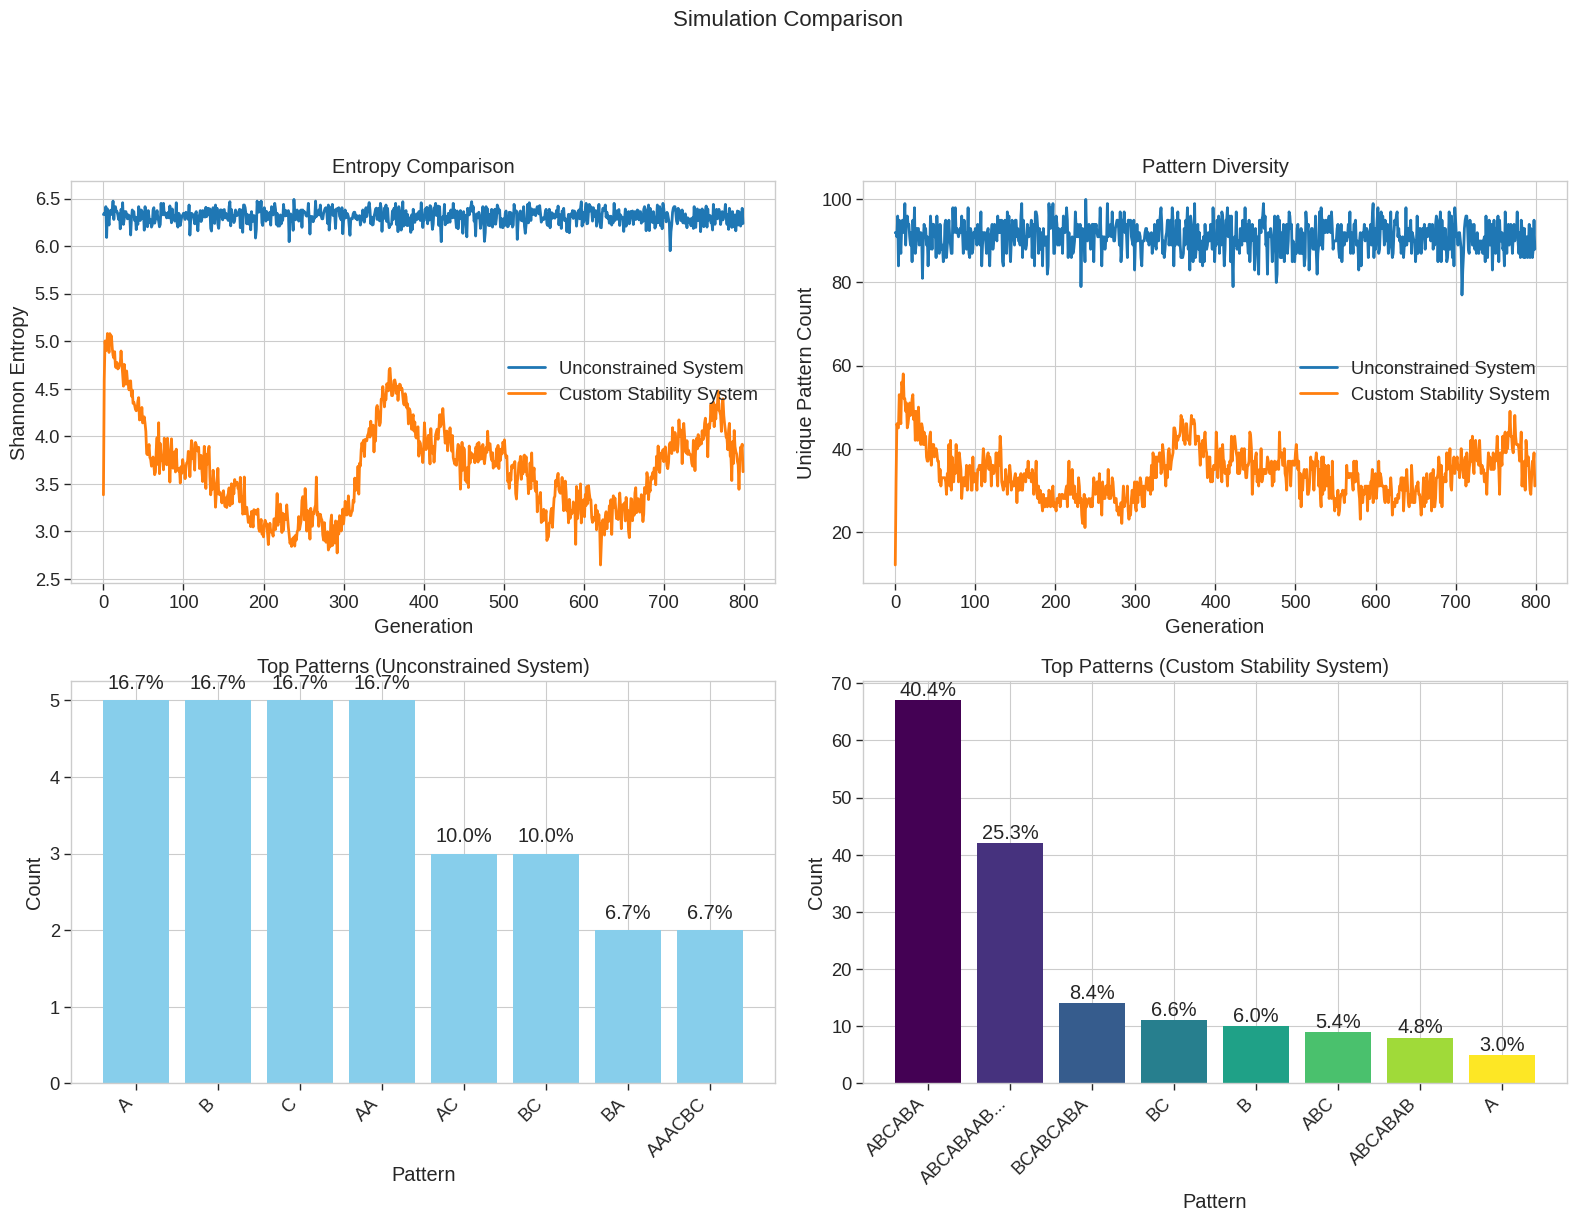

In [ ]:
custom_stability = {
    "ABCABA": 300,      # Very high stability pattern
    "AB": 20, "BC": 20, # Medium stability patterns
    "ABC": 20, "ABA": 20,
    "AC": 10,
    "A": 1, "B": 2, "C": 1
}
interactions_per_gen = 100
replenishment_rate = 5
generations = 800

# Run both simulations
print("Running unconstrained simulation...")
unconstrained_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # No specific stability values
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="uniform",  # Random selection
    seed=42
)

print("\nRunning custom stability simulation...")
custom_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=custom_stability,
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="frequency_proportional",  # Selection based on pattern frequency
    seed=42
)

# Create comparison figure
fig = compare_simulations([unconstrained_result, custom_result])

# Print key metrics
print("\nKey Metrics:")
print(f"Final entropy (Unconstrained): {unconstrained_result['history']['entropy'][-1]:.4f}")
print(f"Final entropy (Custom Stability): {custom_result['history']['entropy'][-1]:.4f}")
print(f"Entropy reduction: {unconstrained_result['history']['entropy'][-1] - custom_result['history']['entropy'][-1]:.4f}")

# Save the figure
fig.savefig('custom_stability_comparison.png', dpi=300, bbox_inches='tight')

# Print top patterns in each system
print("\nTop patterns in Unconstrained system:")
for pattern, count in sorted(unconstrained_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(unconstrained_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

print("\nTop patterns in Custom Stability system:")
for pattern, count in sorted(custom_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(custom_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

Running unconstrained simulation...


Unconstrained System:   0%|          | 0/100 [00:00<?, ?it/s]


Running custom stability simulation...


Custom Stability System:   0%|          | 0/100 [00:00<?, ?it/s]


Key Metrics:
Final entropy (Unconstrained): 6.6651
Final entropy (Custom Stability): 2.9652
Entropy reduction: 3.6999

Top patterns in Unconstrained system:
  A: 5 (3.70%)
  B: 5 (3.70%)
  C: 5 (3.70%)
  AA: 3 (2.22%)
  AC: 2 (1.48%)

Top patterns in Custom Stability system:
  ABCABA: 93 (38.11%)
  ABCABAABCABA: 73 (29.92%)
  ABC: 9 (3.69%)
  BABCABA: 6 (2.46%)
  BC: 5 (2.05%)


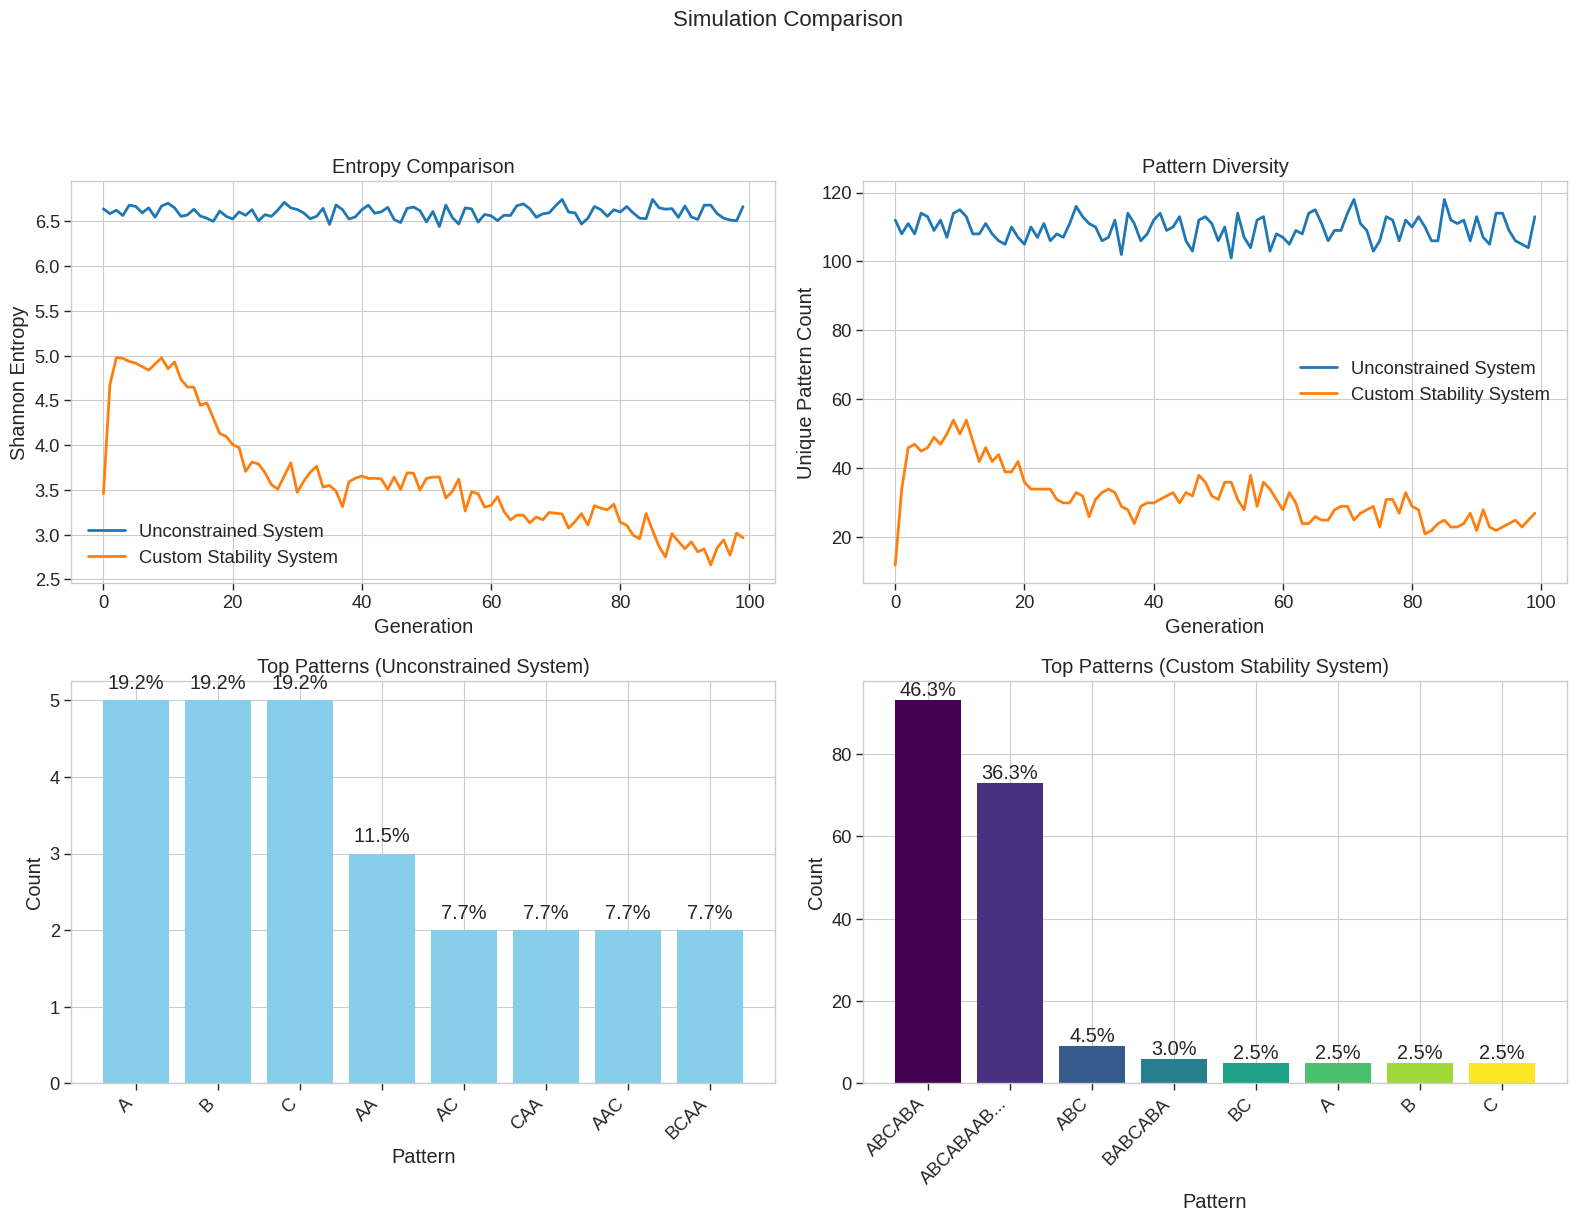

In [ ]:
custom_stability = {
    "ABCABA": 100,      # First high stability pattern
    "ABC": 80,          # Second high stability pattern
    "AB": 15, "BC": 15, # Lower stability patterns
    "ABA": 15,
    "AC": 5,
    "A": 1, "B": 1, "C": 1
}
interactions_per_gen = 120
generations = 100
replenishment_rate = 5

# Run both simulations
print("Running unconstrained simulation...")
unconstrained_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # No specific stability values
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="uniform",  # Random selection
    seed=42
)

print("\nRunning custom stability simulation...")
custom_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=custom_stability,
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="frequency_proportional",  # Selection based on pattern frequency
    seed=42
)

# Create comparison figure
fig = compare_simulations([unconstrained_result, custom_result])

# Print key metrics
print("\nKey Metrics:")
print(f"Final entropy (Unconstrained): {unconstrained_result['history']['entropy'][-1]:.4f}")
print(f"Final entropy (Custom Stability): {custom_result['history']['entropy'][-1]:.4f}")
print(f"Entropy reduction: {unconstrained_result['history']['entropy'][-1] - custom_result['history']['entropy'][-1]:.4f}")

# Save the figure
fig.savefig('custom_stability_comparison.png', dpi=300, bbox_inches='tight')

# Print top patterns in each system
print("\nTop patterns in Unconstrained system:")
for pattern, count in sorted(unconstrained_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(unconstrained_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

print("\nTop patterns in Custom Stability system:")
for pattern, count in sorted(custom_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(custom_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

Running unconstrained simulation...


Unconstrained System:   0%|          | 0/700 [00:00<?, ?it/s]


Running custom stability simulation...


Custom Stability System:   0%|          | 0/700 [00:00<?, ?it/s]


Key Metrics:
Final entropy (Unconstrained): 6.0479
Final entropy (Custom Stability): 2.9979
Entropy reduction: 3.0500

Top patterns in Unconstrained system:
  A: 5 (5.26%)
  B: 5 (5.26%)
  C: 5 (5.26%)
  AA: 3 (3.16%)
  CAA: 2 (2.11%)

Top patterns in Custom Stability system:
  ABCABA: 96 (46.83%)
  ABCABAABCABA: 42 (20.49%)
  A: 5 (2.44%)
  B: 5 (2.44%)
  C: 5 (2.44%)


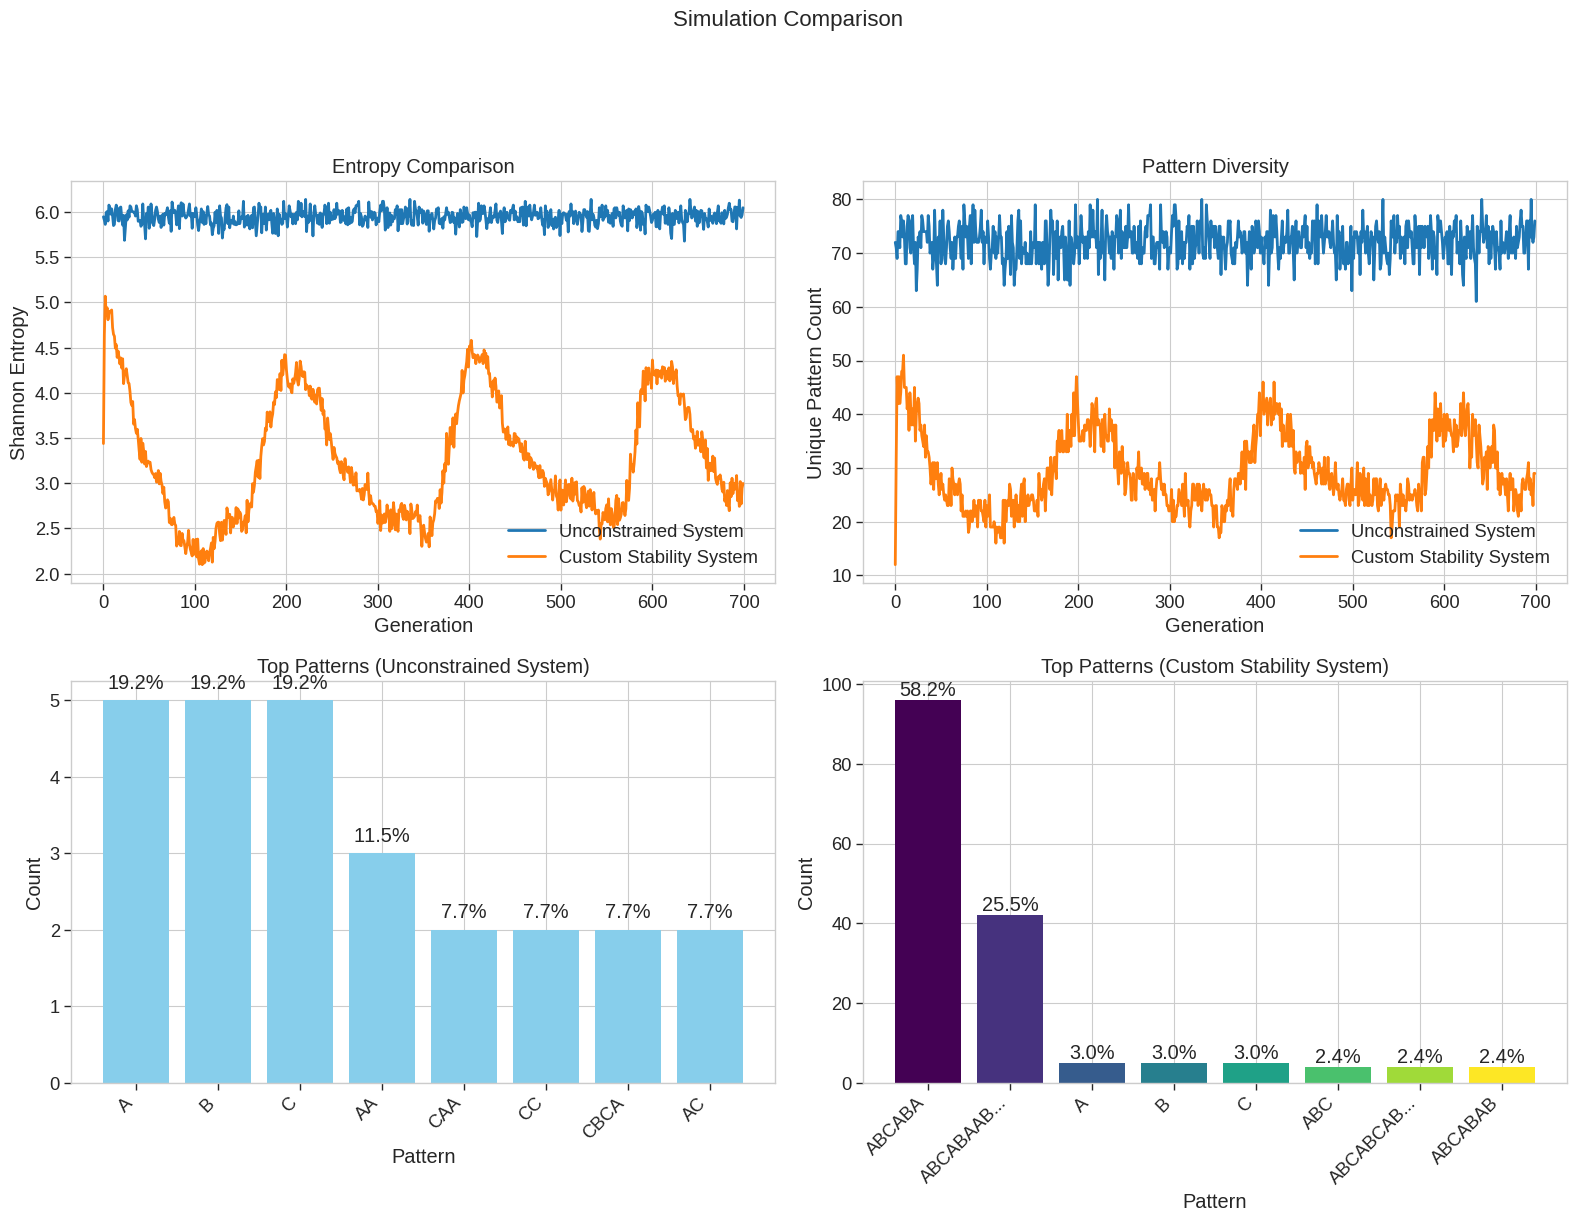

In [ ]:
custom_stability = {
    "ABCABA": 150,      # Highest stability
    "ABC": 60, "ABA": 60, # High stability tier
    "AB": 30, "BC": 30,  # Medium stability tier
    "AC": 10,           # Low stability
    "A": 1, "B": 1, "C": 1
}
interactions_per_gen = 80
generations = 700

replenishment_rate = 5

# Run both simulations
print("Running unconstrained simulation...")
unconstrained_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # No specific stability values
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="uniform",  # Random selection
    seed=42
)

print("\nRunning custom stability simulation...")
custom_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=custom_stability,
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="frequency_proportional",  # Selection based on pattern frequency
    seed=42
)

# Create comparison figure
fig = compare_simulations([unconstrained_result, custom_result])

# Print key metrics
print("\nKey Metrics:")
print(f"Final entropy (Unconstrained): {unconstrained_result['history']['entropy'][-1]:.4f}")
print(f"Final entropy (Custom Stability): {custom_result['history']['entropy'][-1]:.4f}")
print(f"Entropy reduction: {unconstrained_result['history']['entropy'][-1] - custom_result['history']['entropy'][-1]:.4f}")

# Save the figure
fig.savefig('custom_stability_comparison.png', dpi=300, bbox_inches='tight')

# Print top patterns in each system
print("\nTop patterns in Unconstrained system:")
for pattern, count in sorted(unconstrained_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(unconstrained_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

print("\nTop patterns in Custom Stability system:")
for pattern, count in sorted(custom_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(custom_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")


Running unconstrained simulation...


Unconstrained System:   0%|          | 0/600 [00:00<?, ?it/s]


Running custom stability simulation...


Custom Stability System:   0%|          | 0/600 [00:00<?, ?it/s]


Key Metrics:
Final entropy (Unconstrained): 6.5791
Final entropy (Custom Stability): 2.7950
Entropy reduction: 3.7841

Top patterns in Unconstrained system:
  A: 5 (3.70%)
  B: 5 (3.70%)
  C: 5 (3.70%)
  CB: 5 (3.70%)
  CCB: 3 (2.22%)

Top patterns in Custom Stability system:
  ABCABA: 102 (39.84%)
  ABCABAABCABA: 80 (31.25%)
  B: 10 (3.91%)
  ABABCABA: 7 (2.73%)
  AB: 6 (2.34%)


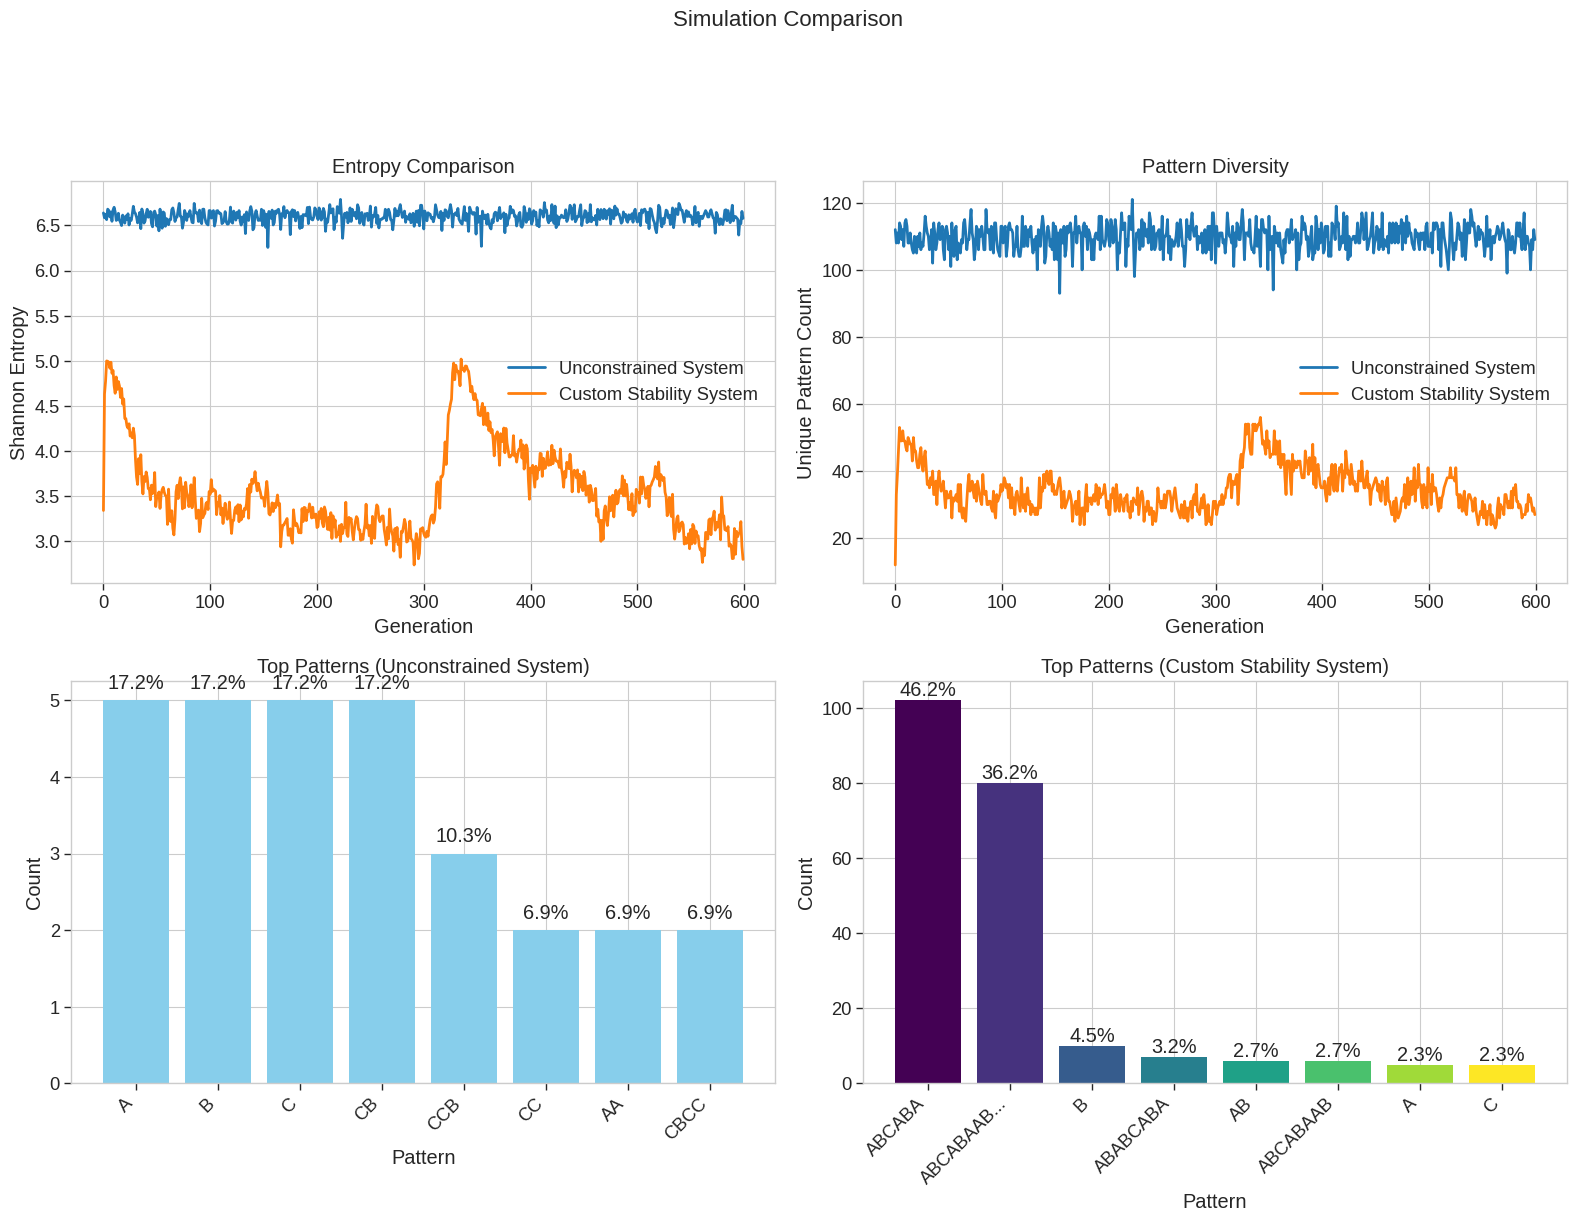

Running unconstrained simulation...


Unconstrained System:   0%|          | 0/400 [00:00<?, ?it/s]


Running custom stability simulation...


Custom Stability System:   0%|          | 0/400 [00:00<?, ?it/s]


Key Metrics:
Final entropy (Unconstrained): 6.1948
Final entropy (Custom Stability): 4.0539
Entropy reduction: 2.1409

Top patterns in Unconstrained system:
  A: 5 (4.35%)
  B: 5 (4.35%)
  C: 5 (4.35%)
  AC: 4 (3.48%)
  BA: 4 (3.48%)

Top patterns in Custom Stability system:
  ABCABA: 78 (30.95%)
  ABCABAABCABA: 26 (10.32%)
  ABC: 24 (9.52%)
  ABA: 15 (5.95%)
  B: 10 (3.97%)


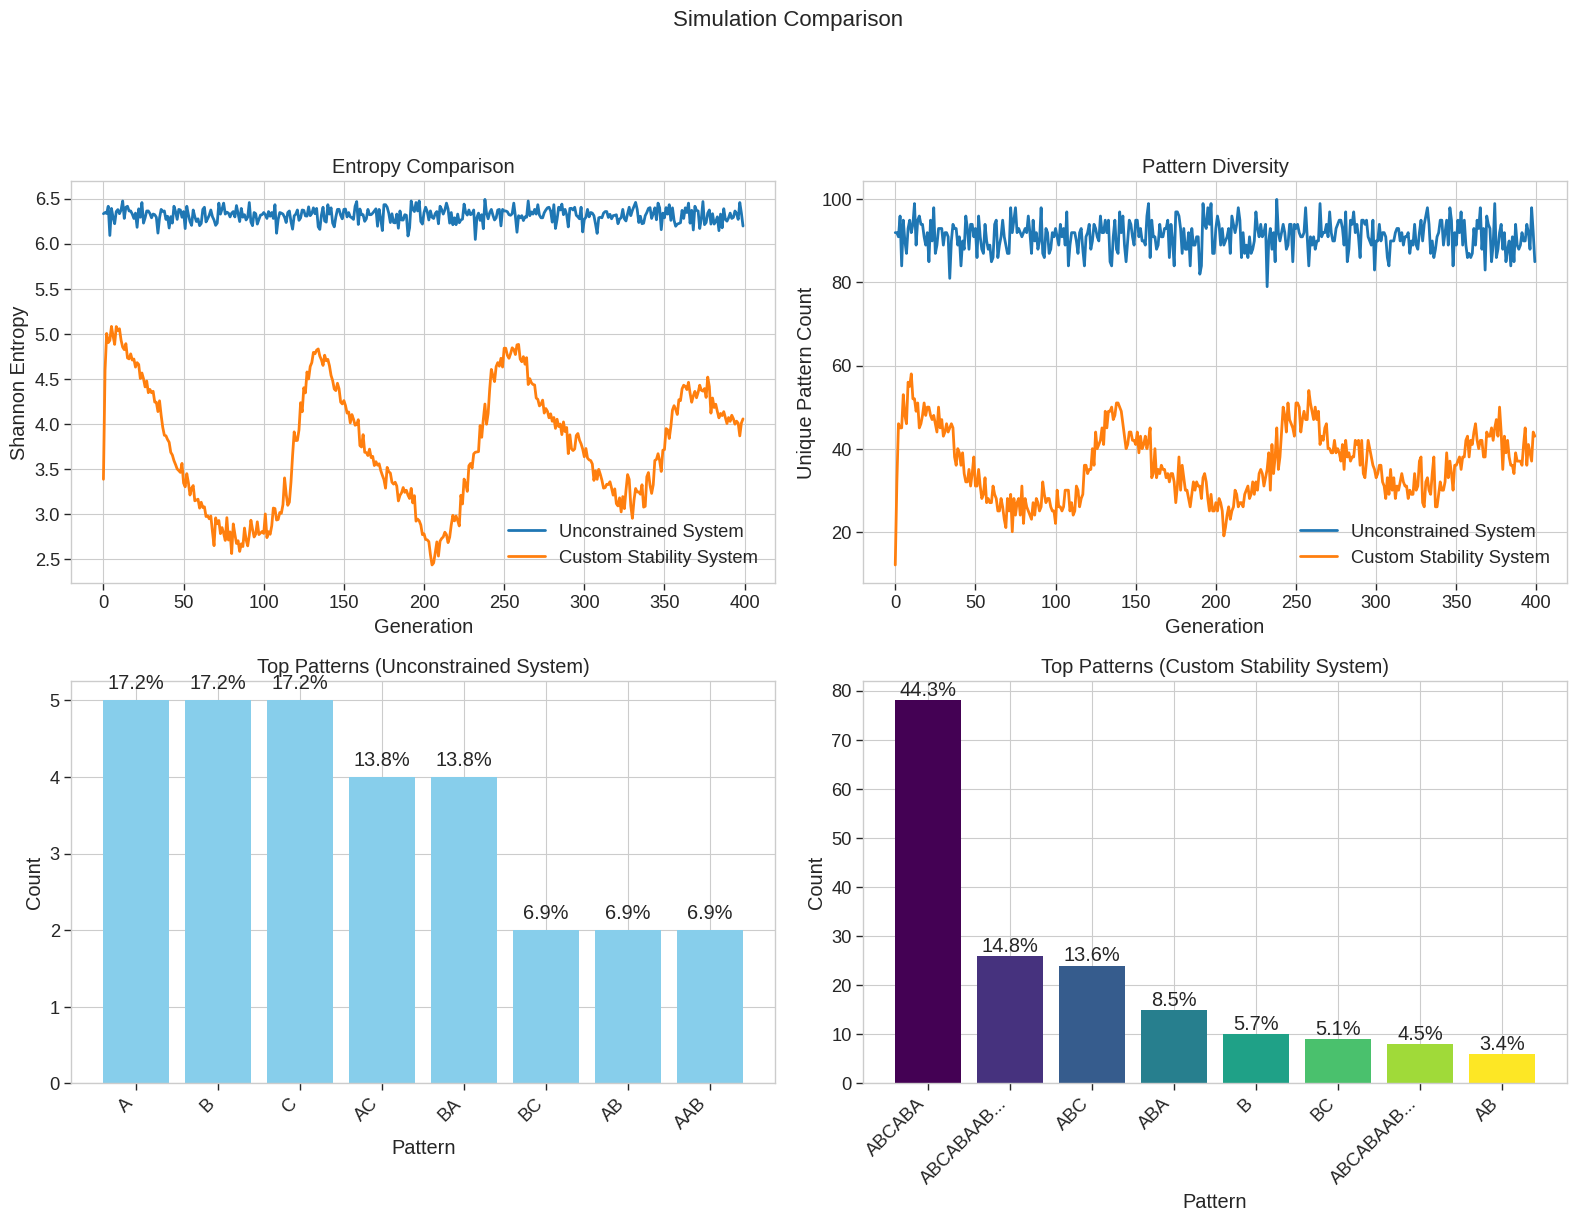

In [ ]:
# Simulation with two competing patterns - oscilattory behavior

custom_stability = {
    "AB": 30, "BC": 30, "ABC": 50, "ABA": 60, "ABCABA": 80,  # High stability for specific compounds
    "AC": 10, "A": 1, "B": 2, "C": 1  # Lower stability for others
}

replenishment_rate = 5
interactions_per_gen=100
generations=400

# Run both simulations
print("Running unconstrained simulation...")
unconstrained_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # No specific stability values
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="uniform",  # Random selection
    seed=42
)

print("\nRunning custom stability simulation...")
custom_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=custom_stability,
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="frequency_proportional",  # Selection based on pattern frequency
    seed=42
)

# Create comparison figure
fig = compare_simulations([unconstrained_result, custom_result])

# Print key metrics
print("\nKey Metrics:")
print(f"Final entropy (Unconstrained): {unconstrained_result['history']['entropy'][-1]:.4f}")
print(f"Final entropy (Custom Stability): {custom_result['history']['entropy'][-1]:.4f}")
print(f"Entropy reduction: {unconstrained_result['history']['entropy'][-1] - custom_result['history']['entropy'][-1]:.4f}")

# Save the figure
fig.savefig('custom_stability_comparison.png', dpi=300, bbox_inches='tight')

# Print top patterns in each system
print("\nTop patterns in Unconstrained system:")
for pattern, count in sorted(unconstrained_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(unconstrained_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

print("\nTop patterns in Custom Stability system:")
for pattern, count in sorted(custom_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(custom_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")


Running simulation for: Balanced High Stability


Custom Stability System:   0%|          | 0/600 [00:00<?, ?it/s]

Final entropy: 3.4758
Top patterns:
  ABCABA: 81 (35.06%) [Stability: 150]
  ABCABAABCABA: 44 (19.05%) [Stability: 1]
  ABC: 16 (6.93%) [Stability: 50]

Running simulation for: Single Dominant Pattern


Custom Stability System:   0%|          | 0/800 [00:00<?, ?it/s]

Final entropy: 3.3634
Top patterns:
  ABCABA: 72 (35.12%) [Stability: 300]
  ABCABAABCABA: 48 (23.41%) [Stability: 1]
  ABCABCABA: 9 (4.39%) [Stability: 1]

Running simulation for: Competing Dominant Patterns


Custom Stability System:   0%|          | 0/600 [00:00<?, ?it/s]

Final entropy: 3.8501
Top patterns:
  ABCABA: 60 (24.79%) [Stability: 100]
  ABC: 37 (15.29%) [Stability: 80]
  ABCABAABCABA: 30 (12.40%) [Stability: 1]

Running simulation for: Multiple Stability Tiers


Custom Stability System:   0%|          | 0/700 [00:00<?, ?it/s]

Final entropy: 2.9979
Top patterns:
  ABCABA: 96 (46.83%) [Stability: 150]
  ABCABAABCABA: 42 (20.49%) [Stability: 1]
  A: 5 (2.44%) [Stability: 1]

Running simulation for: Extreme Stability Gap


Custom Stability System:   0%|          | 0/1000 [00:00<?, ?it/s]

Final entropy: 2.5564
Top patterns:
  ABCABA: 89 (42.58%) [Stability: 500]
  ABCABAABCABA: 64 (30.62%) [Stability: 1]
  ABCABAC: 8 (3.83%) [Stability: 1]


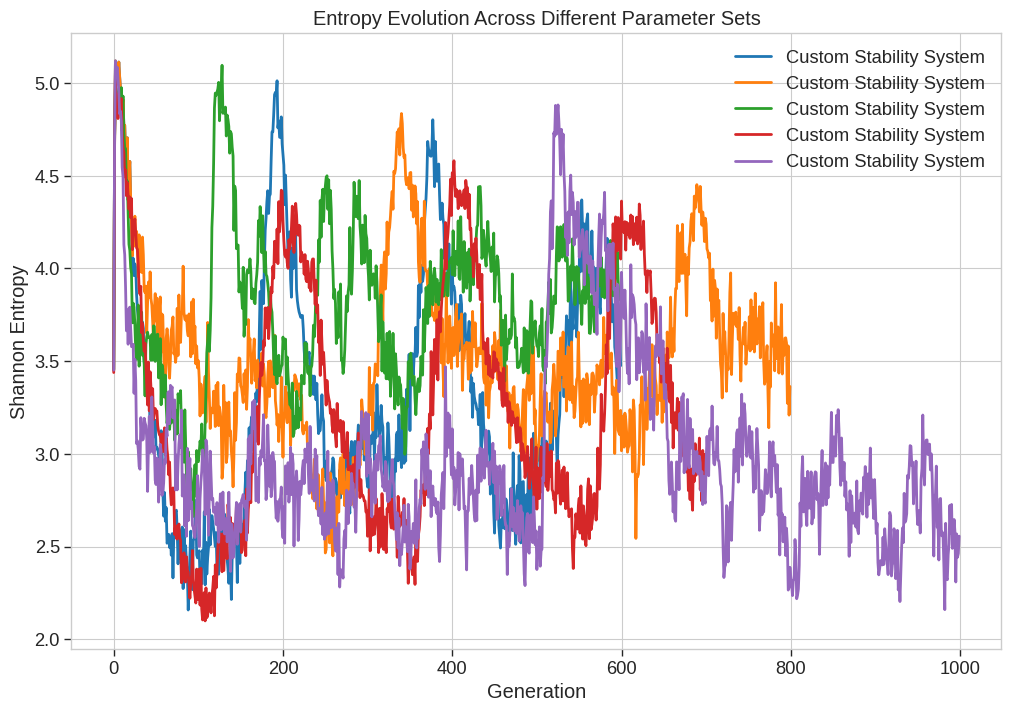


Custom Stability System oscillation periods: [51, 116, 24, 23, 25, 130, 30] (average: 57.0)

Custom Stability System oscillation periods: [80, 59, 59, 131, 22, 31, 56, 53, 40, 25, 102, 55] (average: 59.4)

Custom Stability System oscillation periods: [60, 58, 59, 73, 77, 41, 48, 53] (average: 58.6)

Custom Stability System oscillation periods: [248, 144, 43] (average: 145.0)

Custom Stability System oscillation periods: [48, 37, 75, 54, 83, 35, 32, 48, 21, 85, 26, 67, 32, 25, 42, 44, 27, 35, 60] (average: 46.1)


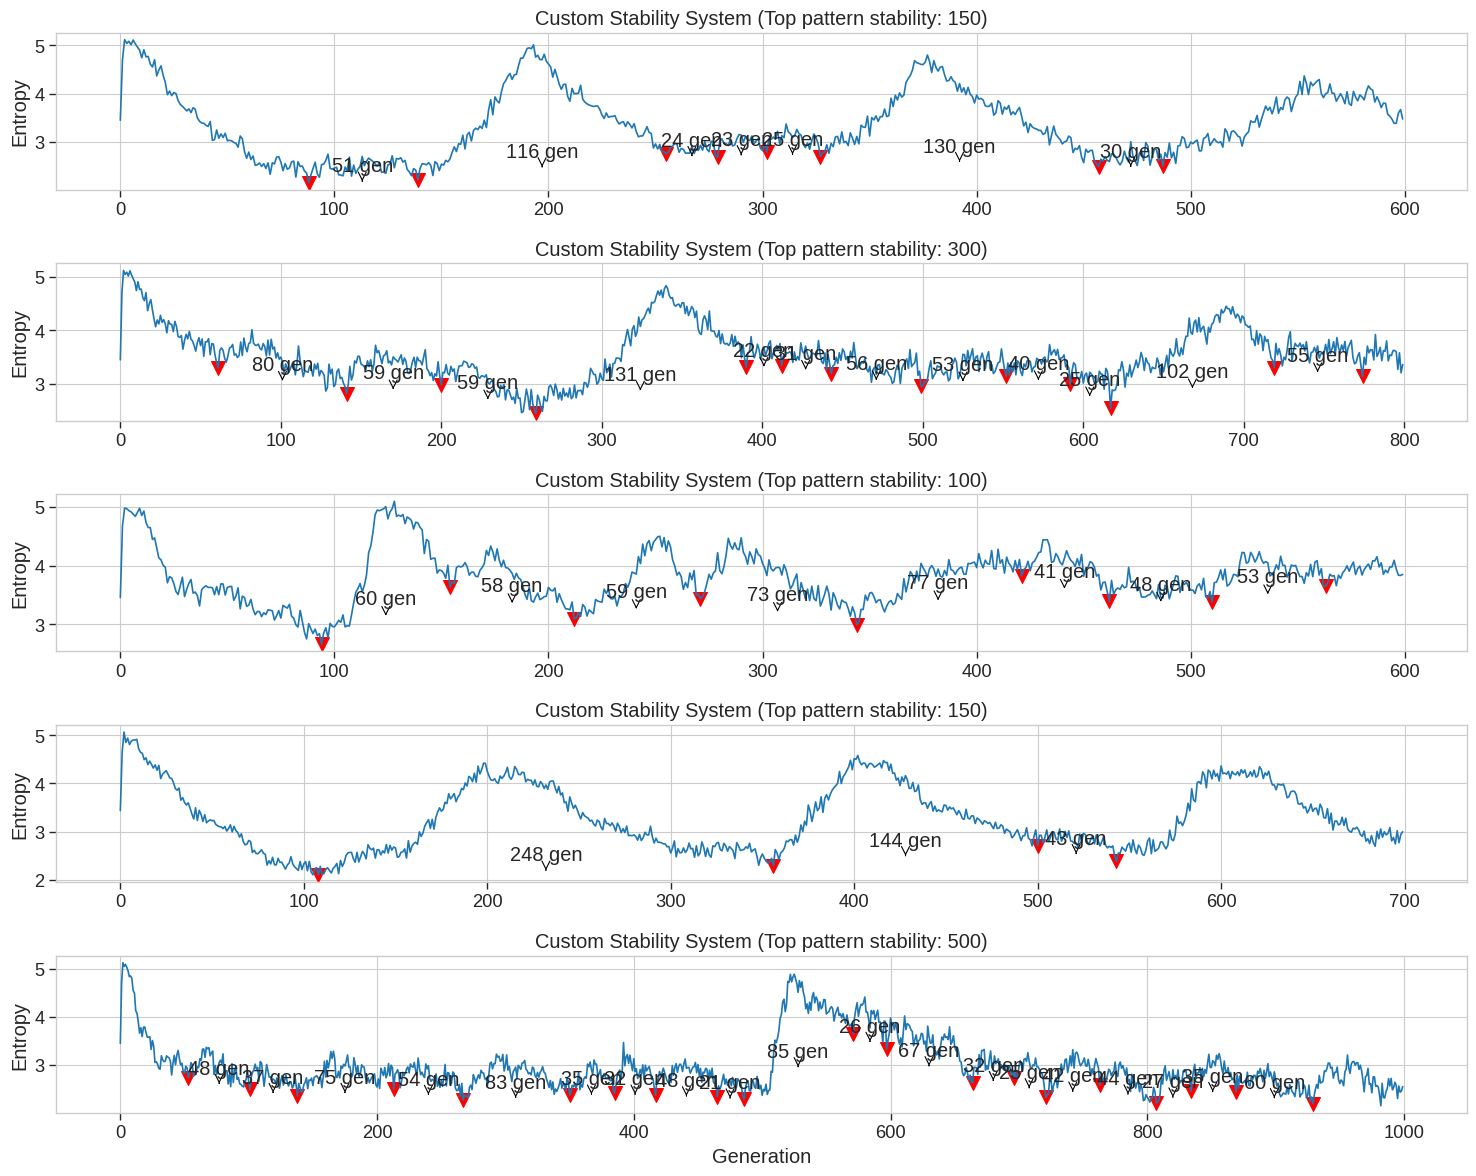

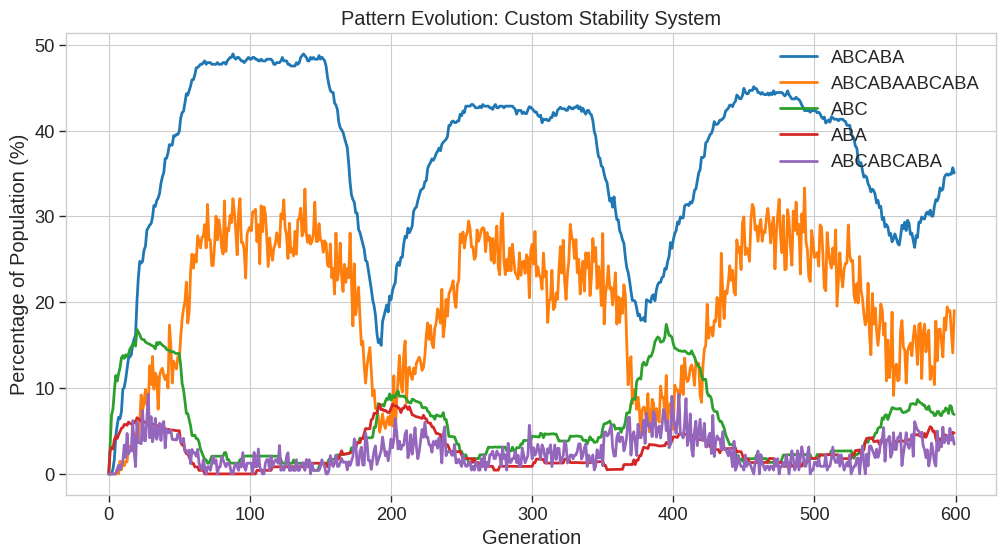

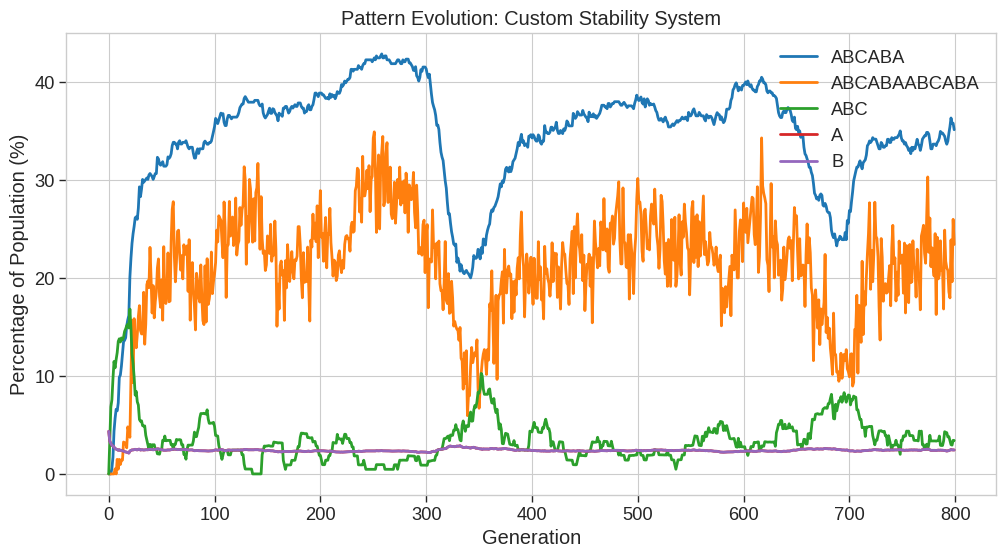

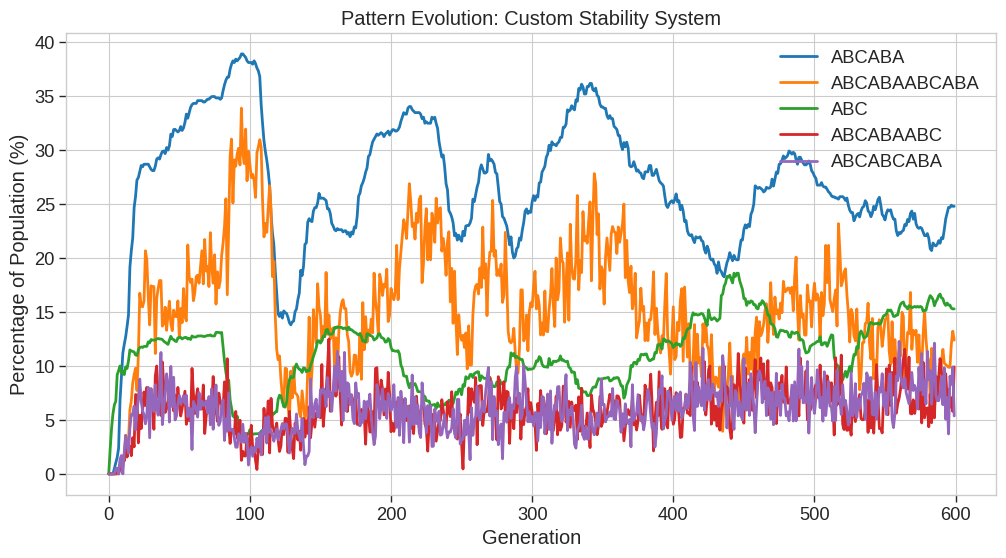

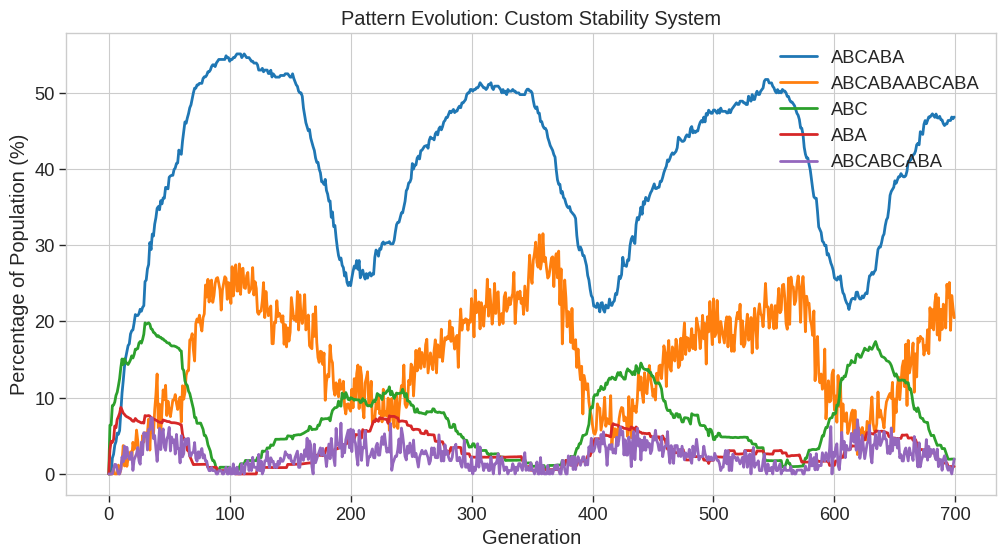

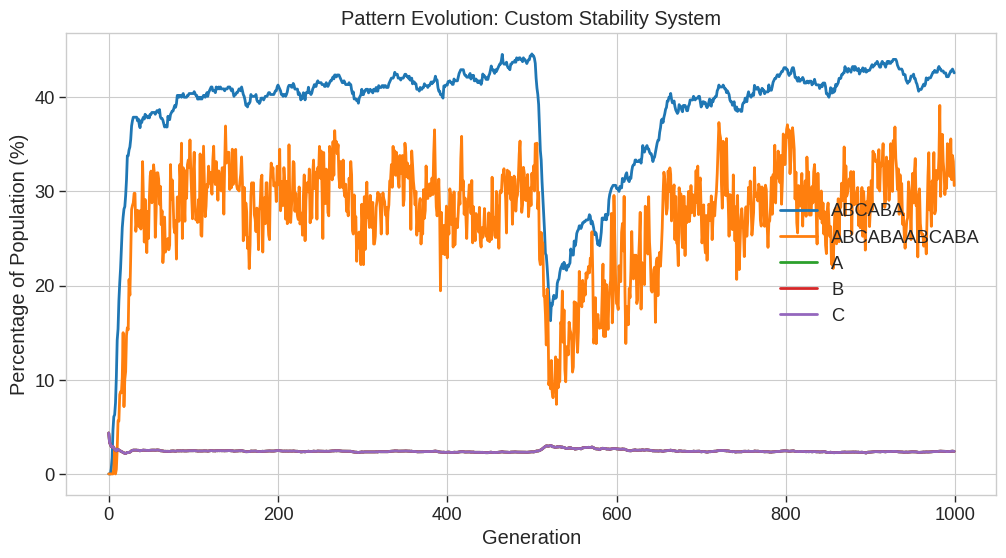

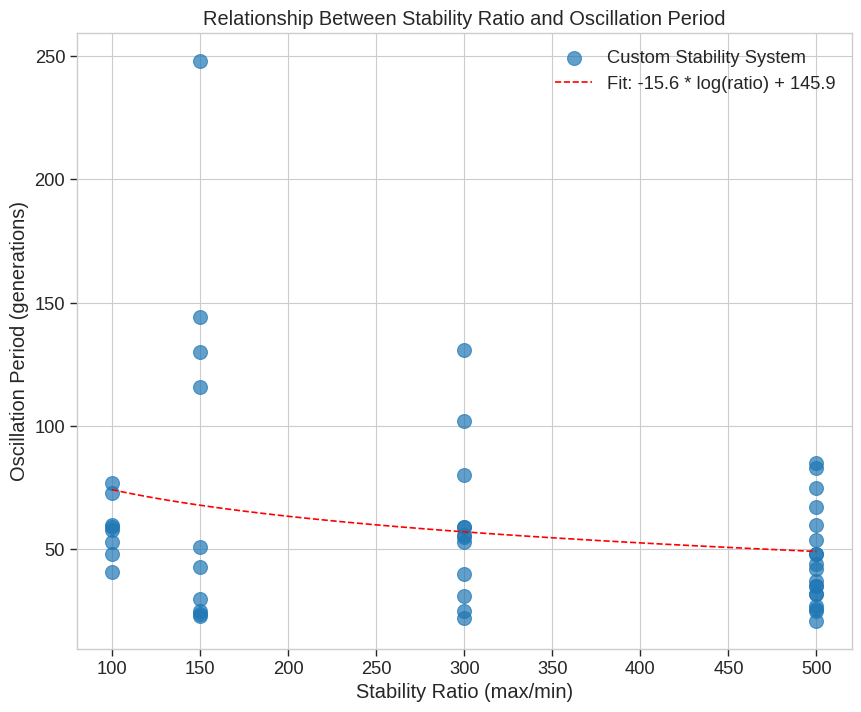

In [ ]:
# Hyperparameter Exploration for SDA Systems
# This cell explores the dynamics across different stability settings

# Define parameter sets to explore
parameter_sets = [
    {
        "name": "Balanced High Stability",
        "stability": {
            "ABCABA": 150, "ABC": 50, "ABA": 50,
            "AB": 20, "BC": 20, "AC": 10,
            "A": 1, "B": 1, "C": 1
        },
        "replenishment_rate": 5,
        "interactions_per_gen": 100,
        "generations": 600
    },
    {
        "name": "Single Dominant Pattern",
        "stability": {
            "ABCABA": 300, "ABC": 20, "ABA": 20,
            "AB": 20, "BC": 20, "AC": 10,
            "A": 1, "B": 1, "C": 1
        },
        "replenishment_rate": 5,
        "interactions_per_gen": 100,
        "generations": 800
    },
    {
        "name": "Competing Dominant Patterns",
        "stability": {
            "ABCABA": 100, "ABC": 80,
            "AB": 15, "BC": 15, "ABA": 15, "AC": 5,
            "A": 1, "B": 1, "C": 1
        },
        "replenishment_rate": 5,
        "interactions_per_gen": 120,
        "generations": 600
    },
    {
        "name": "Multiple Stability Tiers",
        "stability": {
            "ABCABA": 150, "ABC": 60, "ABA": 60,
            "AB": 30, "BC": 30, "AC": 10,
            "A": 1, "B": 1, "C": 1
        },
        "replenishment_rate": 5,
        "interactions_per_gen": 80,
        "generations": 700
    },
    {
        "name": "Extreme Stability Gap",
        "stability": {
            "ABCABA": 500, "ABC": 20, "ABA": 20,
            "AB": 10, "BC": 10, "AC": 5,
            "A": 1, "B": 1, "C": 1
        },
        "replenishment_rate": 5,
        "interactions_per_gen": 100,
        "generations": 1000
    }
]

# Results storage
results = []

# Run simulations for each parameter set
for params in parameter_sets:
    print(f"\nRunning simulation for: {params['name']}")

    result = run_simulation(
        base_elements=['A', 'B', 'C'],
        stability=params['stability'],
        replenishment_rate=params['replenishment_rate'],
        interactions_per_gen=params['interactions_per_gen'],
        generations=params['generations'],
        selection_mode="frequency_proportional",
        name=params['name'],
        seed=42
    )

    results.append(result)

    # Print key metrics
    final_entropy = result['history']['entropy'][-1]
    print(f"Final entropy: {final_entropy:.4f}")

    # Print top patterns
    print("Top patterns:")
    top_patterns = sorted(result['final_population'].items(), key=lambda x: x[1], reverse=True)[:3]
    for pattern, count in top_patterns:
        total = sum(result['final_population'].values())
        percentage = (count / total * 100) if total > 0 else 0
        stability = params['stability'].get(pattern, 1)
        print(f"  {pattern}: {count} ({percentage:.2f}%) [Stability: {stability}]")

# Visualize the entropy time series across all parameter sets
plt.figure(figsize=(12, 8))
for result in results:
    plt.plot(result['history']['entropy'], label=result['name'], linewidth=2)

plt.xlabel('Generation')
plt.ylabel('Shannon Entropy')
plt.title('Entropy Evolution Across Different Parameter Sets')
plt.legend()
plt.grid(True)
plt.savefig('entropy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze oscillation patterns
def find_local_minima(data, window_size=20):
    """Find local minima in a time series"""
    indices = []

    # Need at least 2*window_size+1 elements
    if len(data) < 2*window_size+1:
        return indices

    for i in range(window_size, len(data)-window_size):
        left_window = data[i-window_size:i]
        right_window = data[i+1:i+window_size+1]

        if data[i] <= min(left_window) and data[i] <= min(right_window):
            indices.append(i)

    return indices

# Find oscillation patterns and periods for each parameter set
plt.figure(figsize=(15, 12))

for i, result in enumerate(results):
    # Get entropy data
    entropy = result['history']['entropy']

    # Find local minima (troughs in entropy)
    minima_indices = find_local_minima(entropy)

    # Calculate periods between minima
    periods = []
    for j in range(1, len(minima_indices)):
        periods.append(minima_indices[j] - minima_indices[j-1])

    # Create subplot for this parameter set
    plt.subplot(len(results), 1, i+1)
    plt.plot(entropy, label=result['name'])

    # Mark minima
    if minima_indices:
        plt.scatter(minima_indices, [entropy[idx] for idx in minima_indices], color='red', s=100, marker='v')

    # Annotate periods
    for j, period in enumerate(periods):
        idx1 = minima_indices[j]
        idx2 = minima_indices[j+1]
        mid_idx = (idx1 + idx2) // 2
        mid_val = (entropy[idx1] + entropy[idx2]) / 2
        plt.annotate(f"{period} gen",
                   xy=(mid_idx, mid_val),
                   xytext=(mid_idx, mid_val + 0.2),
                   arrowprops=dict(arrowstyle="->", color='black'),
                   ha='center')

    # Print periods to console
    if periods:
        print(f"\n{result['name']} oscillation periods: {periods} (average: {sum(periods)/len(periods):.1f})")
    else:
        print(f"\n{result['name']}: No clear oscillation pattern detected")

    # Add dominant pattern stability ratio to title
    top_pattern_stability = 0
    if result['final_population']:
        top_pattern = sorted(result['final_population'].items(), key=lambda x: x[1], reverse=True)[0][0]
        top_pattern_stability = parameter_sets[i]['stability'].get(top_pattern, 1)

    plt.title(f"{result['name']} (Top pattern stability: {top_pattern_stability})")
    plt.grid(True)
    plt.ylabel('Entropy')

plt.xlabel('Generation')
plt.tight_layout()
plt.savefig('oscillation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Create visualization of pattern evolution over time
def plot_pattern_evolution(result, num_patterns=5):
    """Plot the evolution of top patterns over time"""
    # Get history of populations
    populations = result['history']['populations']
    generations = len(populations)

    # Find the overall top patterns across all generations
    all_patterns = set()
    for pop in populations:
        all_patterns.update(pop.keys())

    # Count total occurrences of each pattern
    pattern_counts = Counter()
    for pop in populations:
        pattern_counts.update(pop)

    # Get top patterns
    top_patterns = [p for p, _ in pattern_counts.most_common(num_patterns)]

    # Create time series for each top pattern
    pattern_series = {pattern: [] for pattern in top_patterns}

    for pop in populations:
        total = sum(pop.values())
        for pattern in top_patterns:
            percentage = (pop.get(pattern, 0) / total * 100) if total > 0 else 0
            pattern_series[pattern].append(percentage)

    # Plot
    plt.figure(figsize=(12, 6))
    for pattern, series in pattern_series.items():
        plt.plot(series, label=pattern, linewidth=2)

    plt.xlabel('Generation')
    plt.ylabel('Percentage of Population (%)')
    plt.title(f'Pattern Evolution: {result["name"]}')
    plt.legend()
    plt.grid(True)

    return plt.gcf()

# Plot pattern evolution for each parameter set
for result in results:
    fig = plot_pattern_evolution(result)
    fig.savefig(f'pattern_evolution_{result["name"].replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate a phase diagram showing relationship between stability ratio and oscillation period
# Extract stability ratios and observed periods
stability_ratios = []
oscillation_periods = []
parameter_names = []

for i, result in enumerate(results):
    # Get max and min stability values
    stabilities = list(parameter_sets[i]['stability'].values())
    if stabilities:
        max_stability = max(stabilities)
        min_stability = min([s for s in stabilities if s > 0])  # Exclude zero stability
        ratio = max_stability / min_stability

        # Get oscillation periods
        entropy = result['history']['entropy']
        minima_indices = find_local_minima(entropy)
        periods = []
        for j in range(1, len(minima_indices)):
            periods.append(minima_indices[j] - minima_indices[j-1])

        # If we found periods, add to the plot data
        if periods:
            for period in periods:
                stability_ratios.append(ratio)
                oscillation_periods.append(period)
                parameter_names.append(result['name'])

# Create scatter plot of stability ratio vs oscillation period
if stability_ratios and oscillation_periods:
    plt.figure(figsize=(10, 8))

    # Create scatter plot with different markers for each parameter set
    for name in set(parameter_names):
        indices = [i for i, n in enumerate(parameter_names) if n == name]
        plt.scatter([stability_ratios[i] for i in indices],
                   [oscillation_periods[i] for i in indices],
                   label=name, s=100, alpha=0.7)

    # Try to fit a curve if we have enough data points
    if len(stability_ratios) > 3:
        try:
            # Try logarithmic fit: period = a * log(ratio) + b
            coeffs = np.polyfit(np.log(stability_ratios), oscillation_periods, 1)
            x_range = np.linspace(min(stability_ratios), max(stability_ratios), 100)
            plt.plot(x_range, coeffs[0] * np.log(x_range) + coeffs[1], 'r--',
                    label=f'Fit: {coeffs[0]:.1f} * log(ratio) + {coeffs[1]:.1f}')
        except:
            # If fitting fails, just skip it
            pass

    plt.xlabel('Stability Ratio (max/min)')
    plt.ylabel('Oscillation Period (generations)')
    plt.title('Relationship Between Stability Ratio and Oscillation Period')
    plt.legend()
    plt.grid(True)
    plt.savefig('stability_period_relationship.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Not enough oscillation data to create phase diagram")


Scenario 1: Set 1: AA(500), AACA(500)
Alphabet: ['A', 'B', 'C']
Base element stabilities:
  A: 3
  B: 1
  C: 1
All stabilities:
  AA: 500
  AACA: 500
  ACAABC: 500
  BCAA: 500
  CCCB: 200
  BA: 200
  AAC: 50
  ABAABA: 20
  CCB: 20
  BCACC: 20
  ACBCC: 10
  BBBAA: 10
  A: 3
  B: 1
  C: 1

Scenario 2: Set 2: AC(1000), AA(1000)
Alphabet: ['A', 'B', 'C']
Base element stabilities:
  A: 1
  B: 2
  C: 3
All stabilities:
  AC: 1000
  AA: 1000
  ABB: 500
  BBBBA: 500
  AB: 200
  CA: 200
  BBCBCB: 100
  CC: 100
  ABBA: 100
  AAA: 50
  BCABB: 20
  ACB: 10
  C: 3
  B: 2
  A: 1

Scenario 3: Set 3: AAA(1000), BCABA(500)
Alphabet: ['A', 'B', 'C']
Base element stabilities:
  A: 2
  B: 3
  C: 3
All stabilities:
  AAA: 1000
  BCABA: 500
  BCC: 200
  BA: 100
  ABAAC: 50
  ACBA: 20
  ABCA: 20
  CCCCC: 20
  CABBCC: 10
  AC: 10
  CBBB: 10
  BCCA: 10
  B: 3
  C: 3
  A: 2

Scenario 4: Set 4: BA(1000), CCBBB(100)
Alphabet: ['A', 'B', 'C']
Base element stabilities:
  A: 2
  B: 2
  C: 2
All stabilities:
  BA: 1

Custom Stability System:   0%|          | 0/500 [00:00<?, ?it/s]

Simulation completed in 3.87 seconds
Final entropy: 2.6620
Top patterns:
  AACA: 208 (39.17%) [Stability: 500]
  AA: 166 (31.26%) [Stability: 500]
  AAC: 25 (4.71%) [Stability: 50]
  AAAACA: 24 (4.52%) [Stability: 1]
  AACAAACA: 24 (4.52%) [Stability: 1]

Running simulation for: Set 2: AC(1000), AA(1000)


Custom Stability System:   0%|          | 0/500 [00:00<?, ?it/s]

Simulation completed in 1.80 seconds
Final entropy: 3.9966
Top patterns:
  ABB: 125 (28.47%) [Stability: 500]
  AC: 63 (14.35%) [Stability: 1000]
  ABBA: 52 (11.85%) [Stability: 100]
  AA: 26 (5.92%) [Stability: 1000]
  C: 15 (3.42%) [Stability: 3]

Running simulation for: Set 3: AAA(1000), BCABA(500)


Custom Stability System:   0%|          | 0/500 [00:00<?, ?it/s]

Simulation completed in 1.02 seconds
Final entropy: 3.8487
Top patterns:
  BA: 67 (27.24%) [Stability: 100]
  ACBA: 38 (15.45%) [Stability: 20]
  BABA: 17 (6.91%) [Stability: 1]
  B: 15 (6.10%) [Stability: 3]
  C: 15 (6.10%) [Stability: 3]

Running simulation for: Set 4: BA(1000), CCBBB(100)


Custom Stability System:   0%|          | 0/500 [00:00<?, ?it/s]

Simulation completed in 1.30 seconds
Final entropy: 2.1159
Top patterns:
  BA: 188 (58.02%) [Stability: 1000]
  BABA: 68 (20.99%) [Stability: 1]
  A: 10 (3.09%) [Stability: 2]
  B: 10 (3.09%) [Stability: 2]
  C: 10 (3.09%) [Stability: 2]

Running simulation for: Set 5: AC(1000), CCACCB(1000)


Custom Stability System:   0%|          | 0/500 [00:00<?, ?it/s]

Simulation completed in 1.16 seconds
Final entropy: 3.2747
Top patterns:
  BB: 77 (28.62%) [Stability: 200]
  AC: 71 (26.39%) [Stability: 1000]
  BBAC: 19 (7.06%) [Stability: 1]
  ACBB: 17 (6.32%) [Stability: 1]
  BBBB: 17 (6.32%) [Stability: 1]


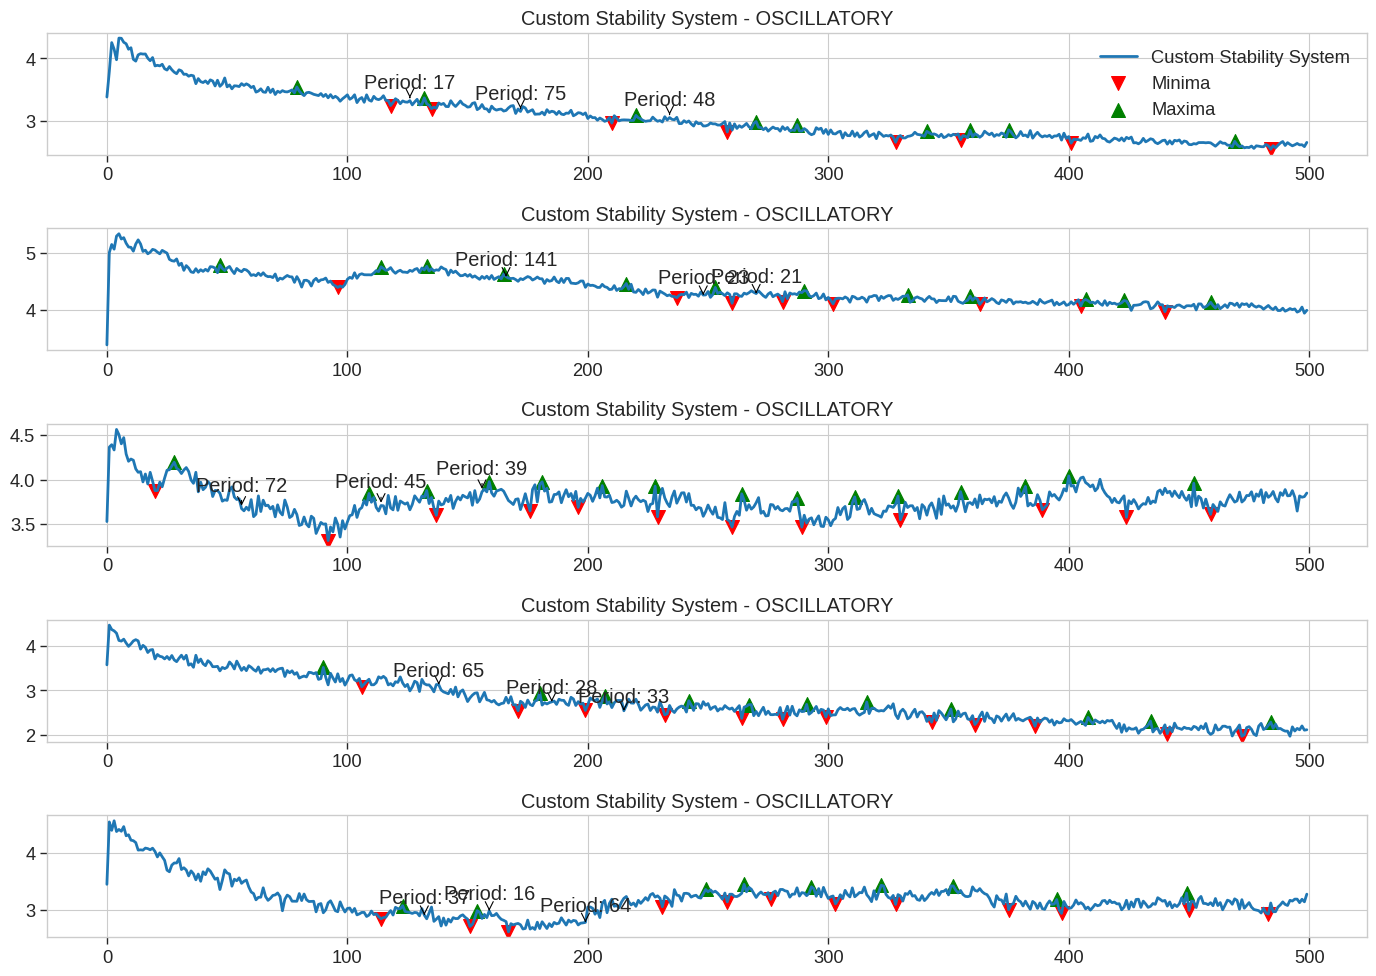


Oscillation Summary:
------------------------------------------------------------------------------------------
Scenario                  Oscillatory  Avg Period   Stability Ratio Highest Stability
------------------------------------------------------------------------------------------
Custom Stability System   True         52.3         500.0           500            
Custom Stability System   True         49.1         1000.0          1000           
Custom Stability System   True         39.9         500.0           1000           
Custom Stability System   True         33.3         500.0           1000           
Custom Stability System   True         33.5         1000.0          1000           


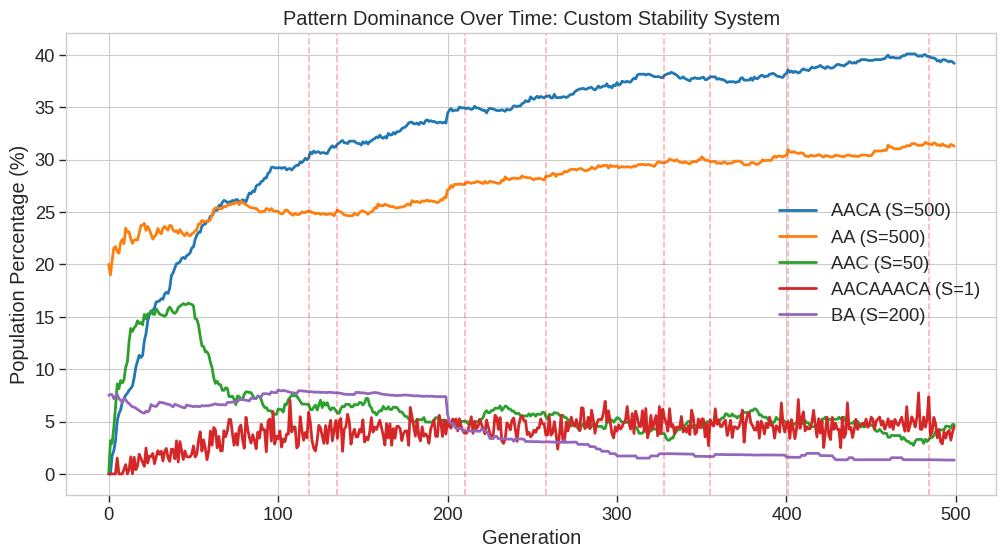

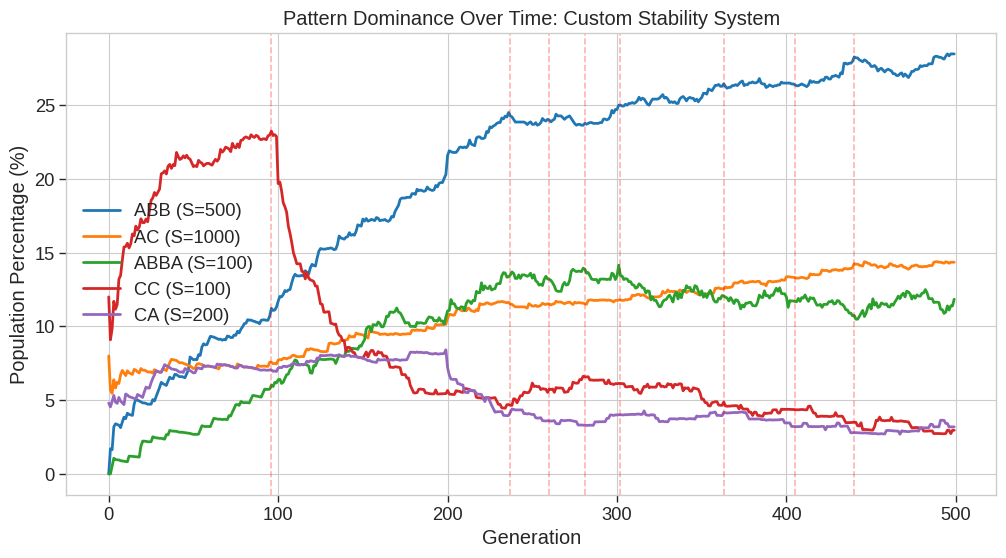

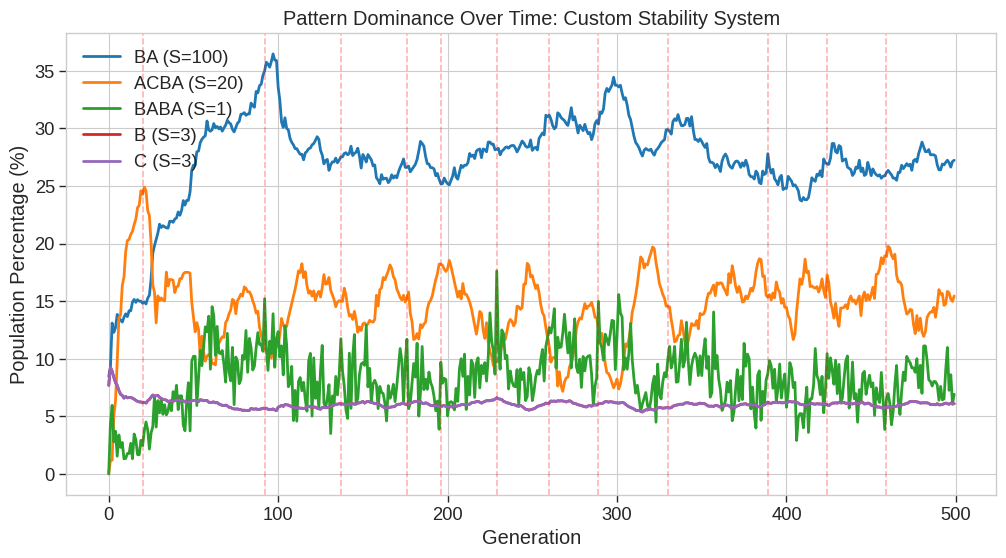

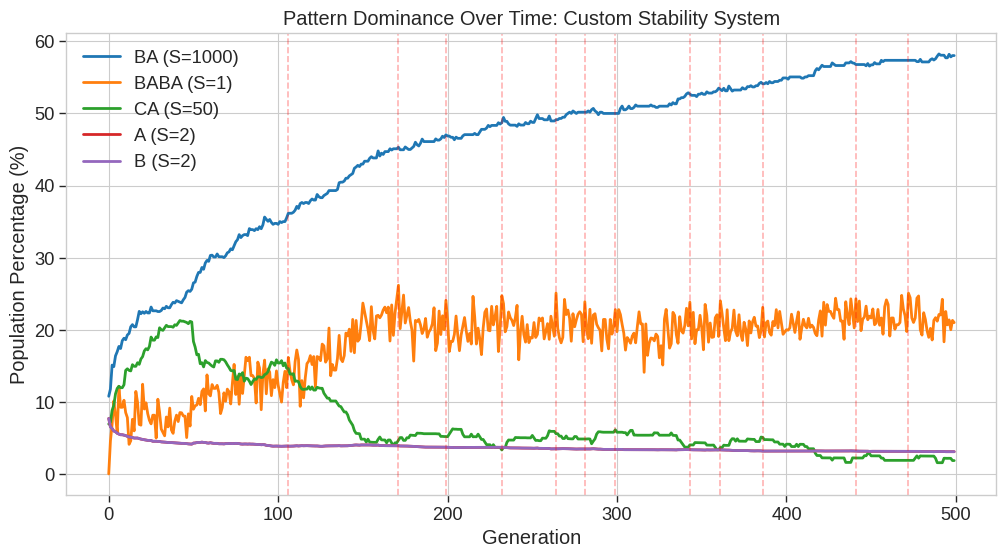

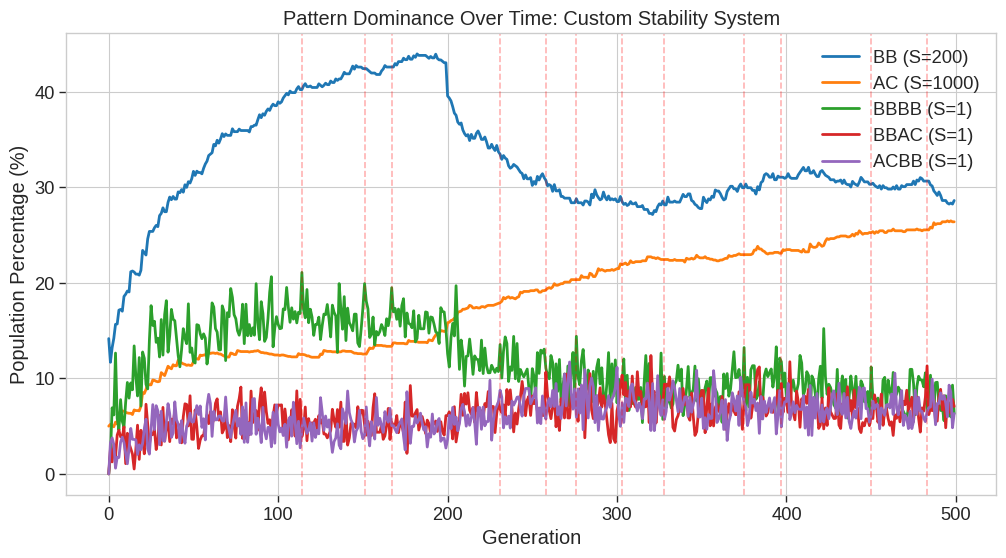

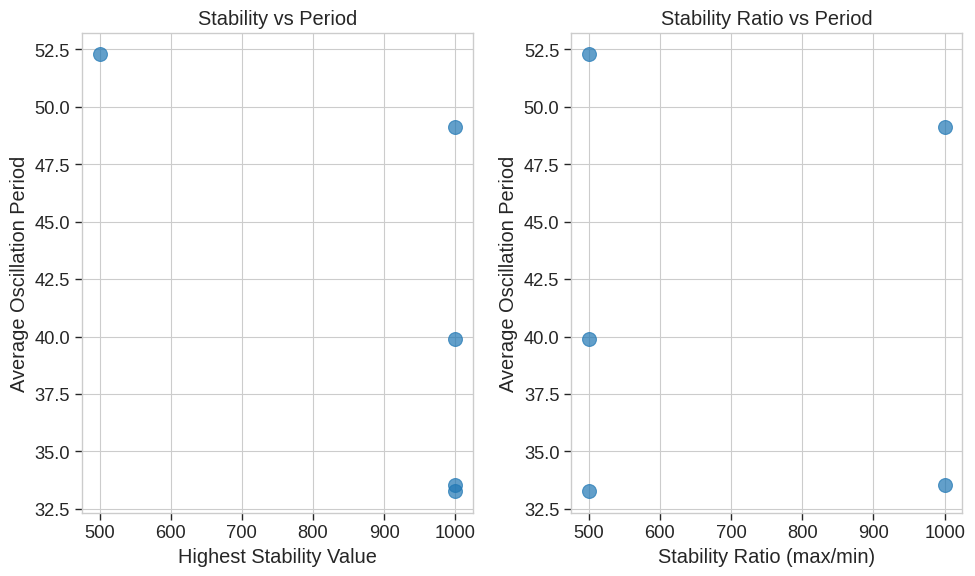

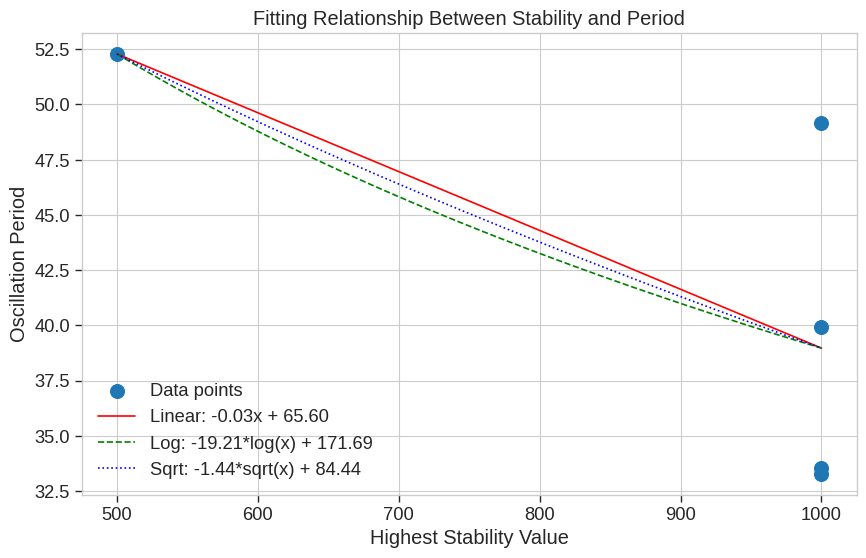


Fitted Relationships:
Linear: Period = -0.0266 * Stability + 65.6039
Logarithmic: Period = -19.2141 * log(Stability) + 171.6937
Square Root: Period = -1.4379 * sqrt(Stability) + 84.4386


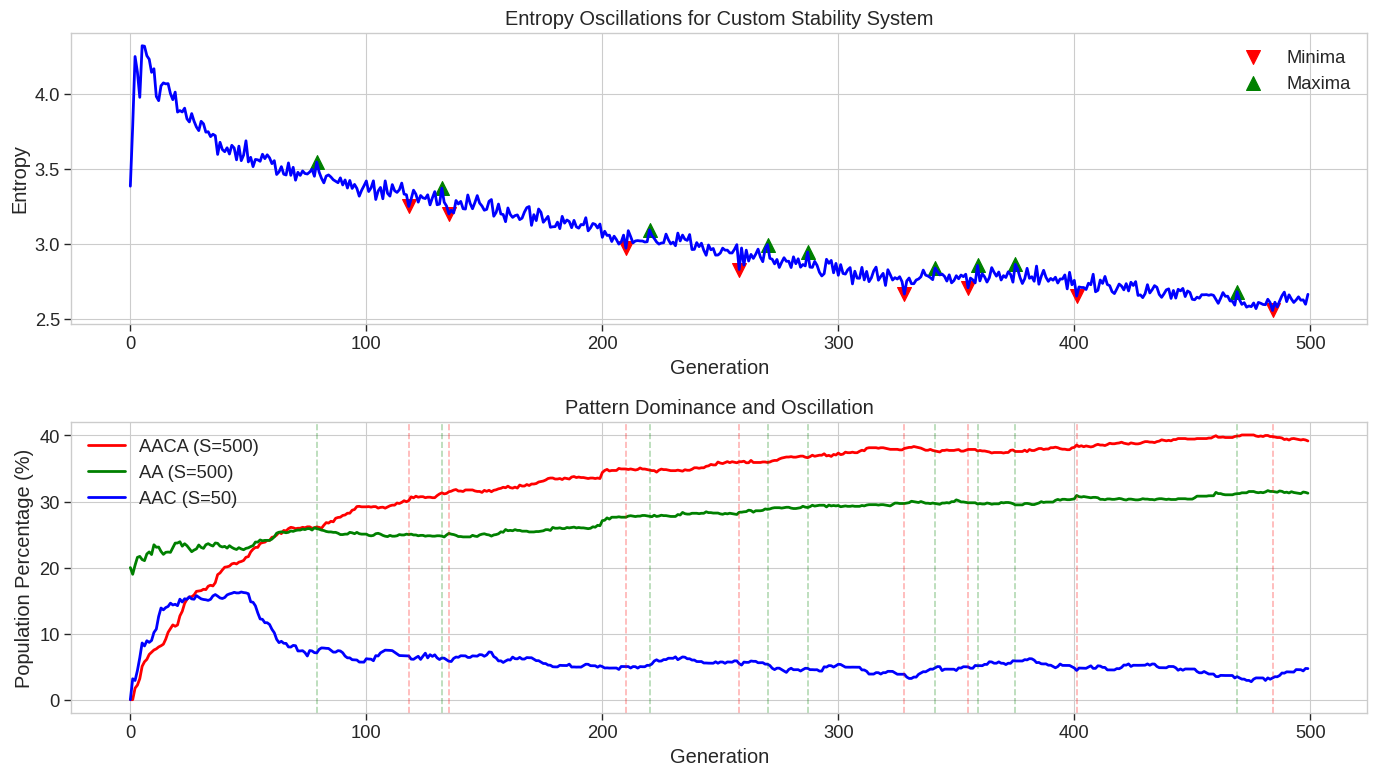

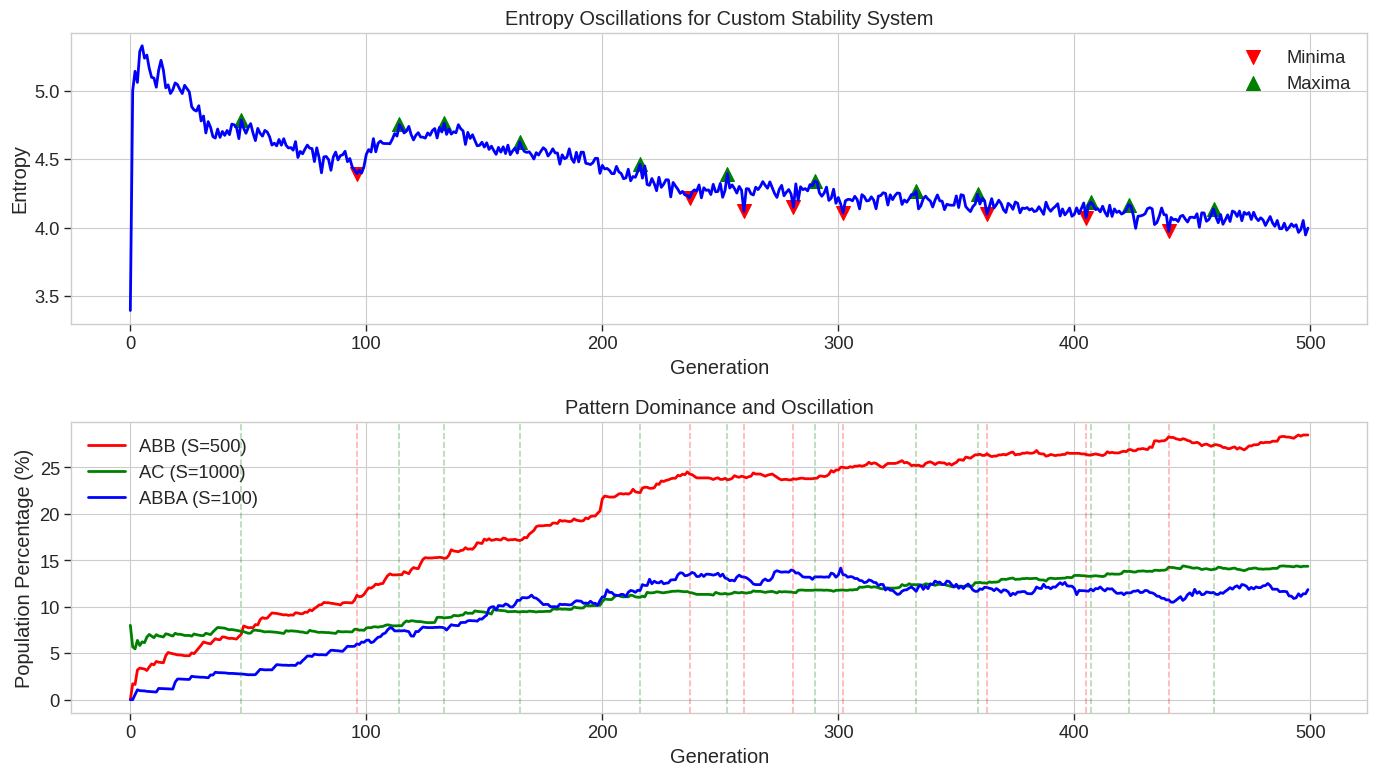

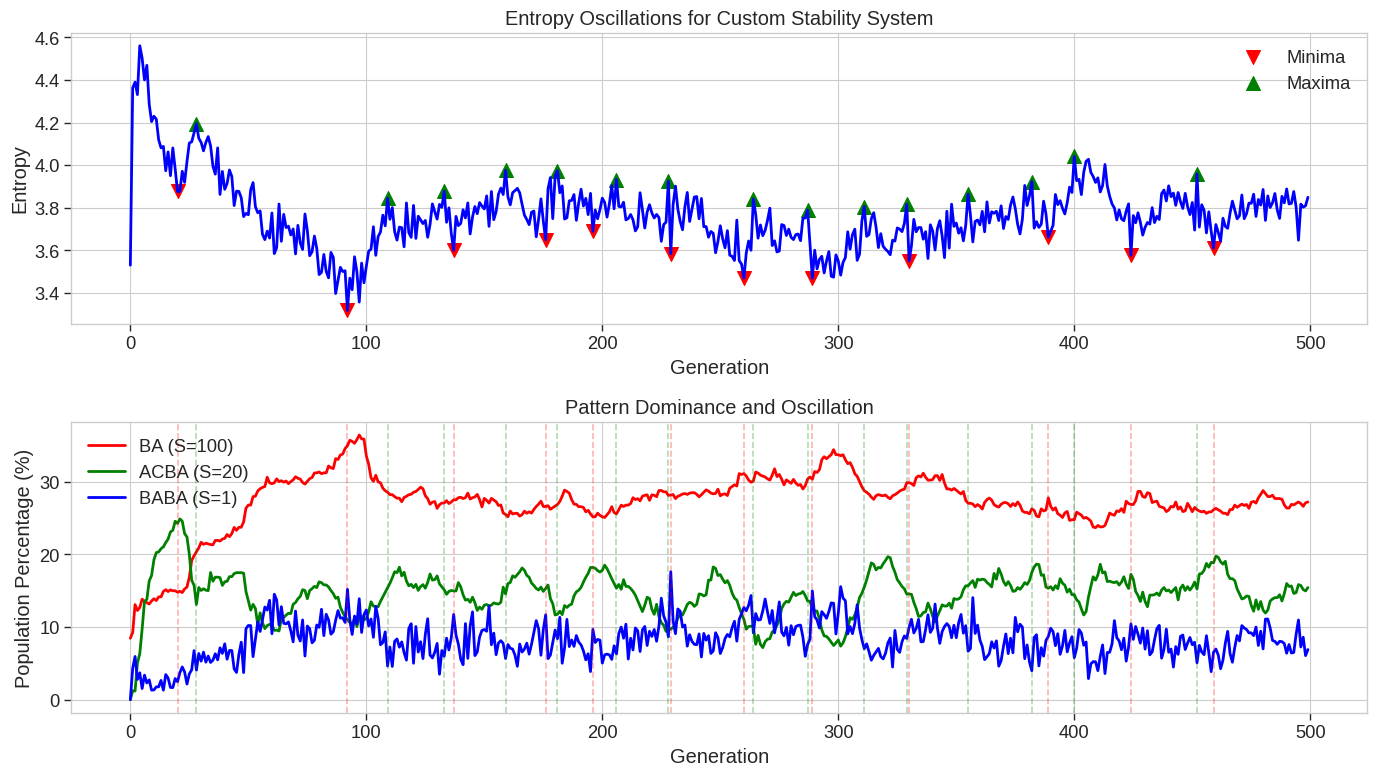

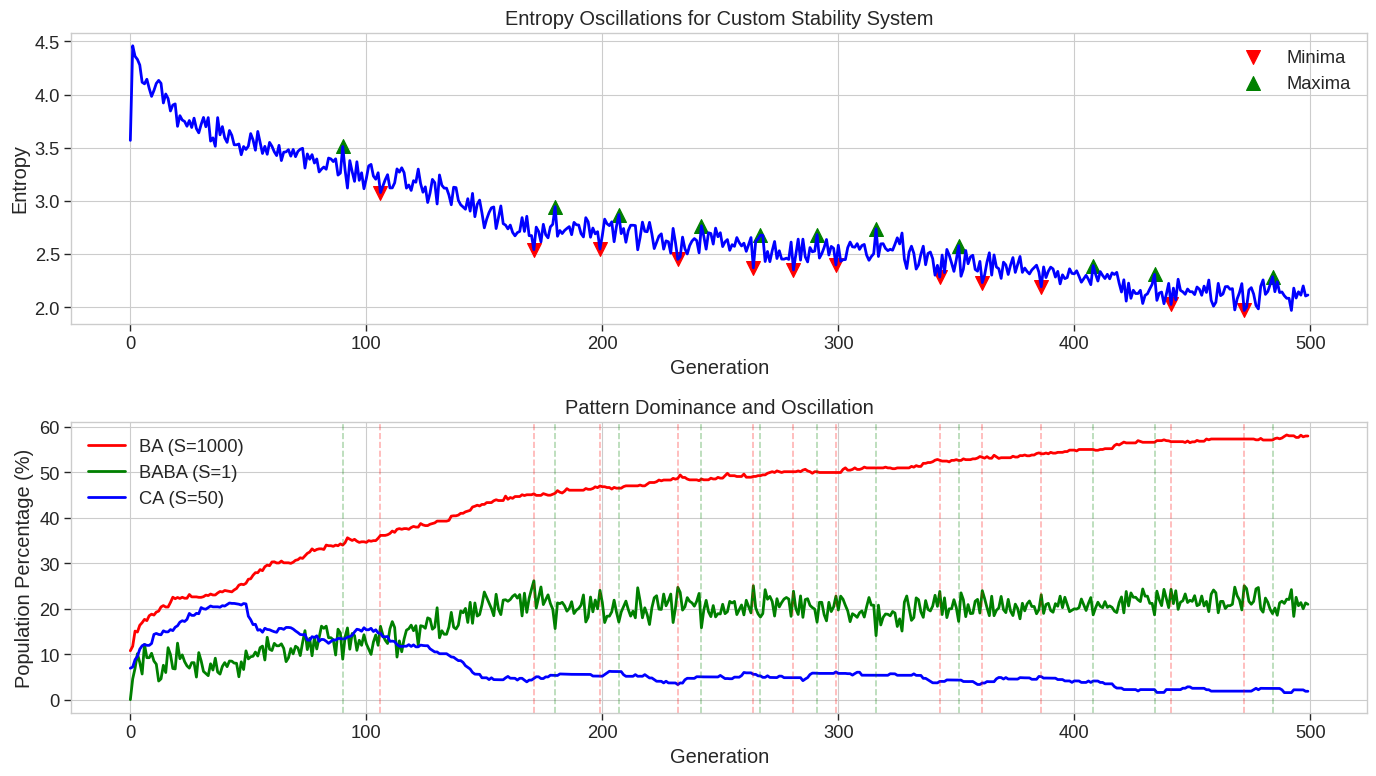

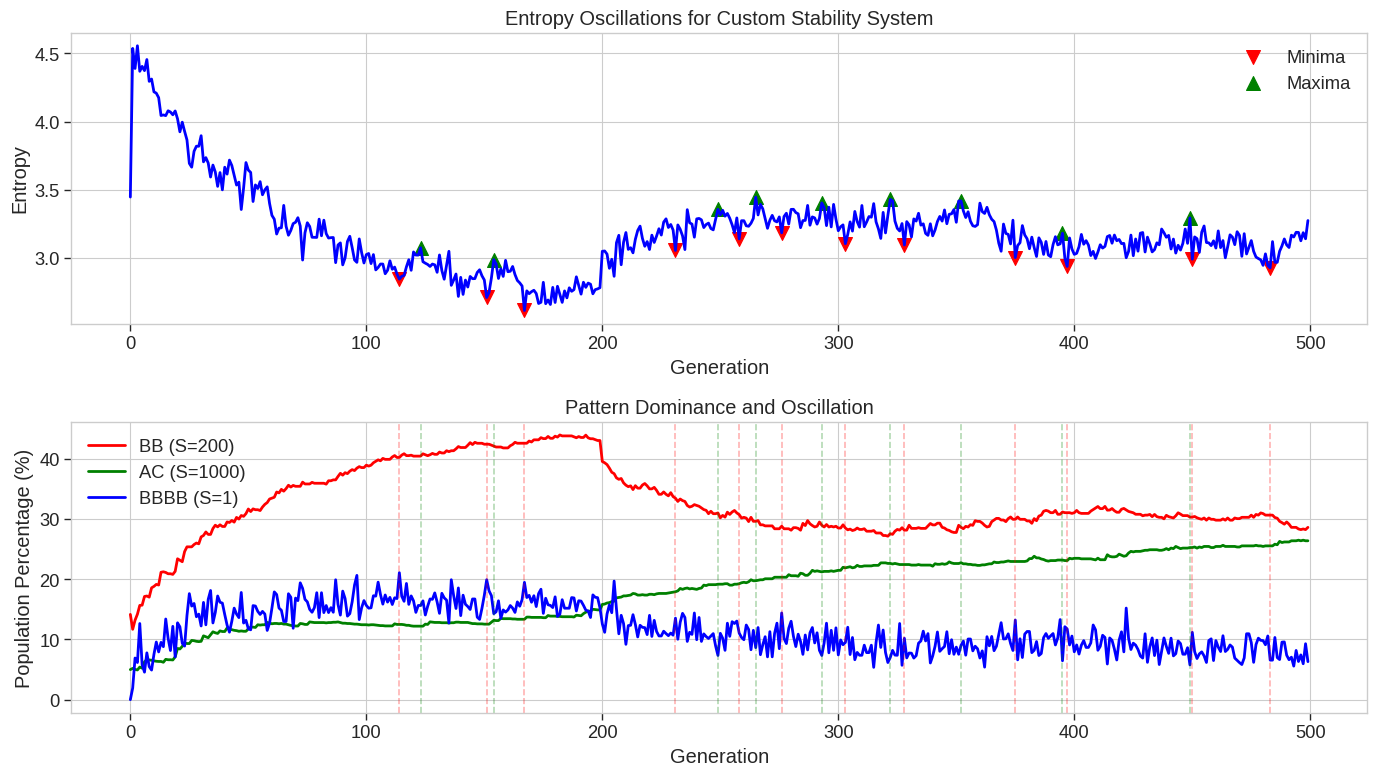


All simulations completed in 26.32 seconds

Testing oscillation period relationships:

Scenario: Custom Stability System
Highest stability: 500
Actual period: 52.3
Linear model prediction: 100.0 (error: 91.3%)
Square root model prediction: 22.4 (error: 57.2%)
Logarithmic model prediction: 67.5 (error: 29.0%)

Scenario: Custom Stability System
Highest stability: 1000
Actual period: 49.1
Linear model prediction: 200.0 (error: 307.0%)
Square root model prediction: 31.6 (error: 35.7%)
Logarithmic model prediction: 75.0 (error: 52.6%)

Scenario: Custom Stability System
Highest stability: 1000
Actual period: 39.9
Linear model prediction: 200.0 (error: 401.1%)
Square root model prediction: 31.6 (error: 20.8%)
Logarithmic model prediction: 75.0 (error: 87.9%)

Scenario: Custom Stability System
Highest stability: 1000
Actual period: 33.3
Linear model prediction: 200.0 (error: 501.1%)
Square root model prediction: 31.6 (error: 5.0%)
Logarithmic model prediction: 75.0 (error: 125.4%)

Scenario: 

In [ ]:
# Simplified Stability Exploration
# Using more distinct stability values with one alphabet

import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time

# Function to generate pattern set
def generate_pattern_set(num_patterns=15, max_length=6, seed=None):
    if seed is not None:
        random.seed(seed)

    # Use just one alphabet
    alphabet = list('ABC')

    # Generate random patterns
    patterns = []

    # Always include base elements
    for char in alphabet:
        patterns.append(char)

    # Generate compound patterns
    while len(patterns) < num_patterns:
        length = random.randint(2, max_length)
        pattern = ''.join(random.choices(alphabet, k=length))
        if pattern not in patterns:
            patterns.append(pattern)

    return patterns, alphabet

# Function to assign distinct stability values
def assign_distinct_stabilities(patterns, base_elements, seed=None):
    if seed is not None:
        random.seed(seed)

    # Create a copy of patterns excluding base elements
    compound_patterns = [p for p in patterns if p not in base_elements]

    # Define distinct stability tiers
    stability_tiers = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

    # Assign stabilities
    stabilities = {}

    # Always assign low stability to base elements (1-3)
    for element in base_elements:
        stabilities[element] = random.randint(1, 3)

    # Assign distinct stabilities to compound patterns
    for pattern in compound_patterns:
        # Choose a random tier except the lowest ones
        tier_index = random.randint(3, len(stability_tiers) - 1)
        stabilities[pattern] = stability_tiers[tier_index]

    return stabilities

# Generate diverse scenarios with distinct stability values
num_scenarios = 5
scenarios = []

for i in range(num_scenarios):
    seed = 42 + i
    patterns, alphabet = generate_pattern_set(num_patterns=15, seed=seed)
    stabilities = assign_distinct_stabilities(patterns, alphabet, seed=seed)

    # Create a descriptive name based on highest stability patterns
    high_stability_patterns = sorted([(p, s) for p, s in stabilities.items() if s >= 100],
                                   key=lambda x: x[1], reverse=True)
    high_stability_str = ', '.join([f"{p}({s})" for p, s in high_stability_patterns[:2]])

    scenario = {
        "name": f"Set {i+1}: {high_stability_str}",
        "patterns": patterns,
        "alphabet": alphabet,
        "stability": stabilities,
        "replenishment_rate": 5,
        "interactions_per_gen": 100,
        "generations": 500,
        "seed": seed
    }

    scenarios.append(scenario)

    # Print scenario details
    print(f"\nScenario {i+1}: {scenario['name']}")
    print(f"Alphabet: {alphabet}")
    print("Base element stabilities:")
    for element in alphabet:
        print(f"  {element}: {stabilities[element]}")
    print("All stabilities:")
    for pattern, stability in sorted(stabilities.items(), key=lambda x: x[1], reverse=True):
        print(f"  {pattern}: {stability}")

# Start timing the simulations
overall_start_time = time.time()

# Run simulations for each scenario
results = []

for scenario in scenarios:
    print(f"\nRunning simulation for: {scenario['name']}")
    start_time = time.time()

    # Run simulation
    result = run_simulation(
        base_elements=scenario['alphabet'],
        stability=scenario['stability'],
        replenishment_rate=scenario['replenishment_rate'],
        interactions_per_gen=scenario['interactions_per_gen'],
        generations=scenario['generations'],
        selection_mode="frequency_proportional",
        name=scenario['name'],
        seed=scenario['seed']
    )

    elapsed = time.time() - start_time
    print(f"Simulation completed in {elapsed:.2f} seconds")

    result['scenario'] = scenario
    results.append(result)

    # Print key metrics
    final_entropy = result['history']['entropy'][-1]
    print(f"Final entropy: {final_entropy:.4f}")

    # Print top patterns
    print("Top patterns:")
    top_patterns = sorted(result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]
    for pattern, count in top_patterns:
        total = sum(result['final_population'].values())
        percentage = (count / total * 100) if total > 0 else 0
        stability = scenario['stability'].get(pattern, 1)
        print(f"  {pattern}: {count} ({percentage:.2f}%) [Stability: {stability}]")

# Analyze oscillation behavior with configurable parameters
def find_oscillations(entropy_data, window_size=15, threshold=0.05, min_periods=2):
    """
    Detect oscillation patterns with configurable sensitivity

    Parameters:
        entropy_data: Time series data to analyze
        window_size: Size of window for detecting local minima/maxima
        threshold: Minimum amplitude as fraction of total range to be considered significant
        min_periods: Minimum number of periods required to classify as oscillatory
    """
    # Identify local minima and maxima
    minima = []
    maxima = []

    for i in range(window_size, len(entropy_data) - window_size):
        # Check if this is a local minimum
        if all(entropy_data[i] <= entropy_data[i-j] for j in range(1, window_size+1)) and \
           all(entropy_data[i] <= entropy_data[i+j] for j in range(1, window_size+1)):
            minima.append(i)

        # Check if this is a local maximum
        if all(entropy_data[i] >= entropy_data[i-j] for j in range(1, window_size+1)) and \
           all(entropy_data[i] >= entropy_data[i+j] for j in range(1, window_size+1)):
            maxima.append(i)

    # Calculate periods between minima
    periods = []
    for i in range(1, len(minima)):
        periods.append(minima[i] - minima[i-1])

    # Calculate amplitudes
    amplitudes = []
    for i in range(min(len(minima), len(maxima))):
        min_idx = minima[i]
        # Find the closest maximum after this minimum
        next_maxima = [m for m in maxima if m > min_idx]
        if next_maxima:
            max_idx = min(next_maxima)
            amplitudes.append(entropy_data[max_idx] - entropy_data[min_idx])

    # Determine if this is "significantly oscillatory"
    is_oscillatory = False
    if periods and amplitudes:
        avg_amplitude = sum(amplitudes) / len(amplitudes)
        # Check if amplitude is significant compared to the range of entropy values
        entropy_range = max(entropy_data) - min(entropy_data)
        if avg_amplitude > threshold * entropy_range and len(periods) >= min_periods:
            is_oscillatory = True

    return {
        'minima': minima,
        'maxima': maxima,
        'periods': periods,
        'average_period': sum(periods) / len(periods) if periods else None,
        'amplitudes': amplitudes,
        'average_amplitude': sum(amplitudes) / len(amplitudes) if amplitudes else None,
        'is_oscillatory': is_oscillatory
    }

# Visualize entropy evolution with oscillation analysis
plt.figure(figsize=(14, 10))

oscillation_summary = []

for i, result in enumerate(results):
    entropy = result['history']['entropy']

    # Analyze oscillations
    osc_data = find_oscillations(entropy)

    # Record summary
    stability_values = list(result['scenario']['stability'].values())
    highest_stability = max(stability_values)
    lowest_stability = min(stability_values)

    summary = {
        'name': result['name'],
        'is_oscillatory': osc_data['is_oscillatory'],
        'avg_period': osc_data['average_period'],
        'avg_amplitude': osc_data['average_amplitude'],
        'high_stability_patterns': len([p for p, s in result['scenario']['stability'].items() if s >= 100]),
        'highest_stability': highest_stability,
        'stability_ratio': highest_stability / lowest_stability if lowest_stability > 0 else highest_stability
    }
    oscillation_summary.append(summary)

    # Plot entropy
    plt.subplot(num_scenarios, 1, i+1)
    plt.plot(entropy, label=result['name'], linewidth=2)

    # Mark minima and maxima if oscillatory
    if osc_data['is_oscillatory']:
        plt.scatter(osc_data['minima'], [entropy[j] for j in osc_data['minima']],
                   color='red', marker='v', s=100, label='Minima')
        plt.scatter(osc_data['maxima'], [entropy[j] for j in osc_data['maxima']],
                   color='green', marker='^', s=100, label='Maxima')

        # Annotate periods
        for j in range(min(3, len(osc_data['periods']))):
            period = osc_data['periods'][j]
            min1, min2 = osc_data['minima'][j], osc_data['minima'][j+1]
            mid_x = (min1 + min2) // 2
            plt.annotate(f"Period: {period}", xy=(mid_x, entropy[mid_x]),
                        xytext=(mid_x, entropy[mid_x] + 0.2),
                        arrowprops=dict(arrowstyle="->"), ha='center')

    osc_status = "OSCILLATORY" if osc_data['is_oscillatory'] else "NON-OSCILLATORY"
    plt.title(f"{result['name']} - {osc_status}")
    if i == 0:  # Only add legend to first subplot
        plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('entropy_oscillations.png', dpi=300, bbox_inches='tight')
plt.show()

# Create oscillation summary table
print("\nOscillation Summary:")
print("-" * 90)
print(f"{'Scenario':<25} {'Oscillatory':<12} {'Avg Period':<12} {'Stability Ratio':<15} {'Highest Stability':<15}")
print("-" * 90)

for summary in oscillation_summary:
    period_str = f"{summary['avg_period']:.1f}" if summary['avg_period'] else "N/A"
    print(f"{summary['name']:<25} {str(summary['is_oscillatory']):<12} {period_str:<12} {summary['stability_ratio']:<15.1f} {summary['highest_stability']:<15}")

# Generate pattern evolution plots
for i, result in enumerate(results):
    # Track top patterns over time
    populations = result['history']['populations']

    # Find the overall top patterns across all generations
    all_pattern_counts = Counter()
    for pop in populations:
        all_pattern_counts.update(pop)

    # Get top patterns across all generations (may include patterns not dominant at end)
    top_patterns = [p for p, _ in all_pattern_counts.most_common(5)]

    # Track percentage of each pattern over time
    pattern_percentages = {p: [] for p in top_patterns}

    for pop in populations:
        total = sum(pop.values())
        for p in top_patterns:
            percentage = (pop.get(p, 0) / total * 100) if total > 0 else 0
            pattern_percentages[p].append(percentage)

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Plot each pattern's percentage
    for pattern, percentages in pattern_percentages.items():
        stability = result['scenario']['stability'].get(pattern, 1)
        plt.plot(percentages, label=f"{pattern} (S={stability})", linewidth=2)

    # Mark oscillation minima if detected
    osc_data = find_oscillations(result['history']['entropy'])
    if osc_data['is_oscillatory']:
        for min_idx in osc_data['minima']:
            plt.axvline(x=min_idx, color='red', linestyle='--', alpha=0.3)

    plt.xlabel('Generation')
    plt.ylabel('Population Percentage (%)')
    plt.title(f'Pattern Dominance Over Time: {result["name"]}')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'pattern_evolution_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

# If we have oscillatory systems, analyze relationship between stability and period
oscillatory_data = [s for s in oscillation_summary if s['is_oscillatory'] and s['avg_period']]

if len(oscillatory_data) >= 2:  # Need at least 2 points for a meaningful plot
    plt.figure(figsize=(10, 6))

    # Create scatterplot of highest stability vs period
    plt.subplot(1, 2, 1)
    plt.scatter([d['highest_stability'] for d in oscillatory_data],
               [d['avg_period'] for d in oscillatory_data],
               s=100, alpha=0.7)

    plt.xlabel('Highest Stability Value')
    plt.ylabel('Average Oscillation Period')
    plt.title('Stability vs Period')
    plt.grid(True)

    # Create scatterplot of stability ratio vs period
    plt.subplot(1, 2, 2)
    plt.scatter([d['stability_ratio'] for d in oscillatory_data],
               [d['avg_period'] for d in oscillatory_data],
               s=100, alpha=0.7)

    plt.xlabel('Stability Ratio (max/min)')
    plt.ylabel('Average Oscillation Period')
    plt.title('Stability Ratio vs Period')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('stability_period_relationship.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Try to fit relationship
    if len(oscillatory_data) >= 3:  # Need at least 3 points for meaningful fitting
        try:
            x = np.array([d['highest_stability'] for d in oscillatory_data])
            y = np.array([d['avg_period'] for d in oscillatory_data])

            # Try linear fit: period = a * stability + b
            linear_coeffs = np.polyfit(x, y, 1)

            # Try logarithmic fit: period = a * log(stability) + b
            log_coeffs = np.polyfit(np.log(x), y, 1)

            # Try square root fit: period = a * sqrt(stability) + b
            sqrt_coeffs = np.polyfit(np.sqrt(x), y, 1)

            # Create plot with all fits
            plt.figure(figsize=(10, 6))
            plt.scatter(x, y, s=100, label='Data points')

            # Generate fitted lines
            x_range = np.linspace(min(x), max(x), 100)
            plt.plot(x_range, linear_coeffs[0] * x_range + linear_coeffs[1],
                    'r-', label=f'Linear: {linear_coeffs[0]:.2f}x + {linear_coeffs[1]:.2f}')
            plt.plot(x_range, log_coeffs[0] * np.log(x_range) + log_coeffs[1],
                    'g--', label=f'Log: {log_coeffs[0]:.2f}*log(x) + {log_coeffs[1]:.2f}')
            plt.plot(x_range, sqrt_coeffs[0] * np.sqrt(x_range) + sqrt_coeffs[1],
                    'b:', label=f'Sqrt: {sqrt_coeffs[0]:.2f}*sqrt(x) + {sqrt_coeffs[1]:.2f}')

            plt.xlabel('Highest Stability Value')
            plt.ylabel('Oscillation Period')
            plt.title('Fitting Relationship Between Stability and Period')
            plt.legend()
            plt.grid(True)
            plt.savefig('period_fits.png', dpi=300, bbox_inches='tight')
            plt.show()

            print("\nFitted Relationships:")
            print(f"Linear: Period = {linear_coeffs[0]:.4f} * Stability + {linear_coeffs[1]:.4f}")
            print(f"Logarithmic: Period = {log_coeffs[0]:.4f} * log(Stability) + {log_coeffs[1]:.4f}")
            print(f"Square Root: Period = {sqrt_coeffs[0]:.4f} * sqrt(Stability) + {sqrt_coeffs[1]:.4f}")
        except:
            print("Could not fit relationships - insufficient data or numerical issues")
else:
    print("Not enough oscillatory systems to analyze period relationships")

# Visualize the relationship between pattern dominance and oscillation
for i, result in enumerate(results):
    osc_data = find_oscillations(result['history']['entropy'])

    if osc_data['is_oscillatory'] and osc_data['minima'] and osc_data['maxima']:
        plt.figure(figsize=(14, 8))

        # First subplot: entropy with marked extrema
        plt.subplot(2, 1, 1)
        plt.plot(result['history']['entropy'], 'b-', linewidth=2)
        plt.scatter(osc_data['minima'], [result['history']['entropy'][j] for j in osc_data['minima']],
                   color='red', marker='v', s=100, label='Minima')
        plt.scatter(osc_data['maxima'], [result['history']['entropy'][j] for j in osc_data['maxima']],
                   color='green', marker='^', s=100, label='Maxima')
        plt.xlabel('Generation')
        plt.ylabel('Entropy')
        plt.title(f'Entropy Oscillations for {result["name"]}')
        plt.legend()
        plt.grid(True)

        # Second subplot: Pattern percentages
        plt.subplot(2, 1, 2)

        # Get the overall top patterns
        all_pattern_counts = Counter()
        for pop in result['history']['populations']:
            all_pattern_counts.update(pop)

        # Get top 3 patterns
        top_patterns = [p for p, _ in all_pattern_counts.most_common(3)]
        colors = ['r', 'g', 'b']

        # Track percentage of each pattern
        for idx, pattern in enumerate(top_patterns):
            pattern_percentages = []
            for pop in result['history']['populations']:
                total = sum(pop.values())
                percentage = (pop.get(pattern, 0) / total * 100) if total > 0 else 0
                pattern_percentages.append(percentage)

            stability = result['scenario']['stability'].get(pattern, 1)
            plt.plot(pattern_percentages, color=colors[idx], linewidth=2,
                    label=f"{pattern} (S={stability})")

        # Mark minima and maxima
        for min_idx in osc_data['minima']:
            plt.axvline(x=min_idx, color='red', linestyle='--', alpha=0.3)

        for max_idx in osc_data['maxima']:
            plt.axvline(x=max_idx, color='green', linestyle='--', alpha=0.3)

        plt.xlabel('Generation')
        plt.ylabel('Population Percentage (%)')
        plt.title('Pattern Dominance and Oscillation')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'oscillation_pattern_relationship_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

print(f"\nAll simulations completed in {time.time() - overall_start_time:.2f} seconds")

# Test whether oscillation characteristics match predictions
if len(oscillatory_data) >= 2:
    print("\nTesting oscillation period relationships:")

    # For each oscillatory scenario, calculate predicted period based on different models
    for summary in oscillatory_data:
        stability = summary['highest_stability']
        actual_period = summary['avg_period']

        # Model 1: Period proportional to stability (linear)
        linear_prediction = stability / 5  # Simple linear scaling

        # Model 2: Period proportional to sqrt(stability)
        sqrt_prediction = 10 * np.sqrt(stability / 100)

        # Model 3: Period proportional to log(stability)
        log_prediction = 50 * np.log10(stability) / np.log10(100)

        # Print comparison
        print(f"\nScenario: {summary['name']}")
        print(f"Highest stability: {stability}")
        print(f"Actual period: {actual_period:.1f}")
        print(f"Linear model prediction: {linear_prediction:.1f} (error: {abs(actual_period-linear_prediction)/actual_period*100:.1f}%)")
        print(f"Square root model prediction: {sqrt_prediction:.1f} (error: {abs(actual_period-sqrt_prediction)/actual_period*100:.1f}%)")
        print(f"Logarithmic model prediction: {log_prediction:.1f} (error: {abs(actual_period-log_prediction)/actual_period*100:.1f}%)")

Running Uniform to Custom intervention experiment...
Phase 1: Before intervention (200 generations)


Custom Stability System:   0%|          | 0/200 [00:00<?, ?it/s]

Phase 2: After intervention (200 generations)


Custom Stability System:   0%|          | 0/200 [00:00<?, ?it/s]

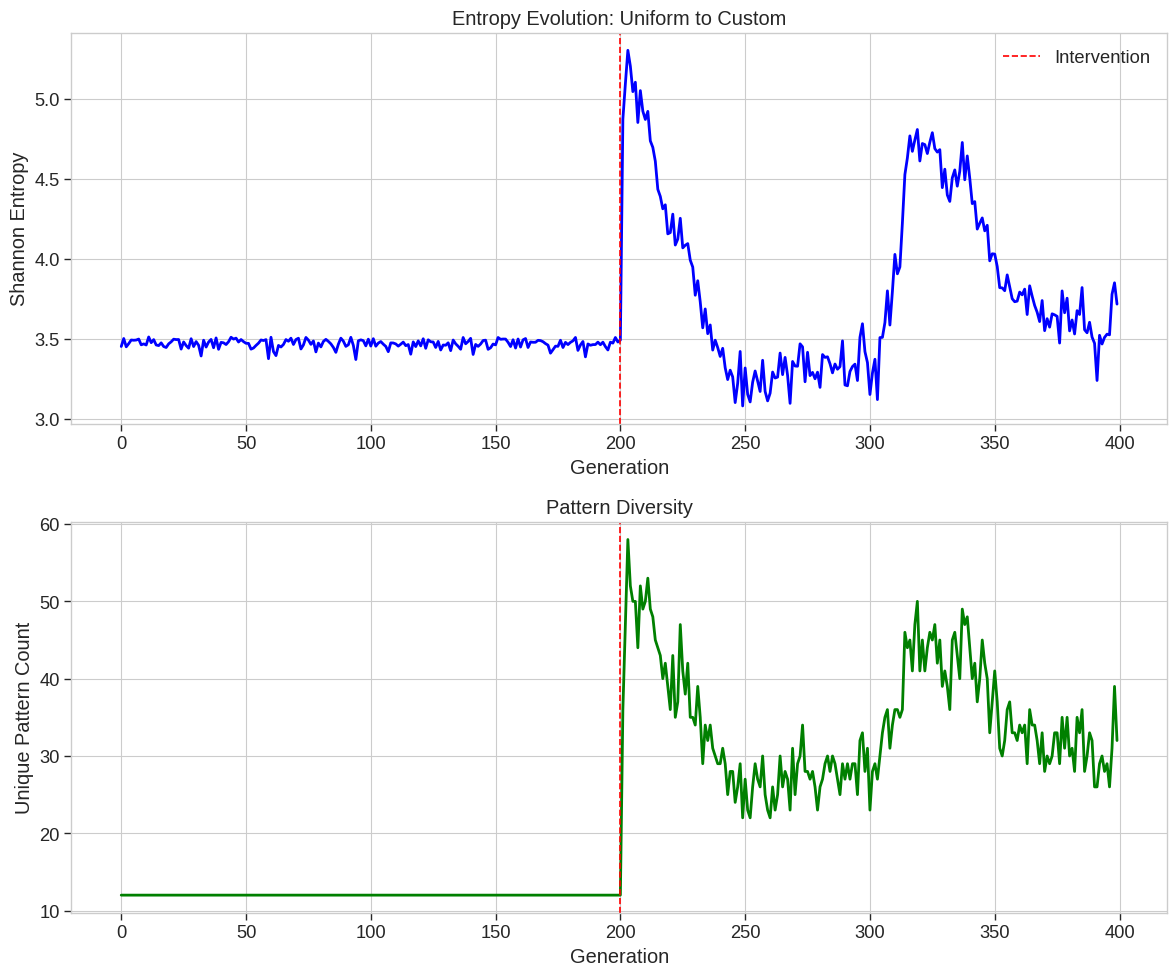

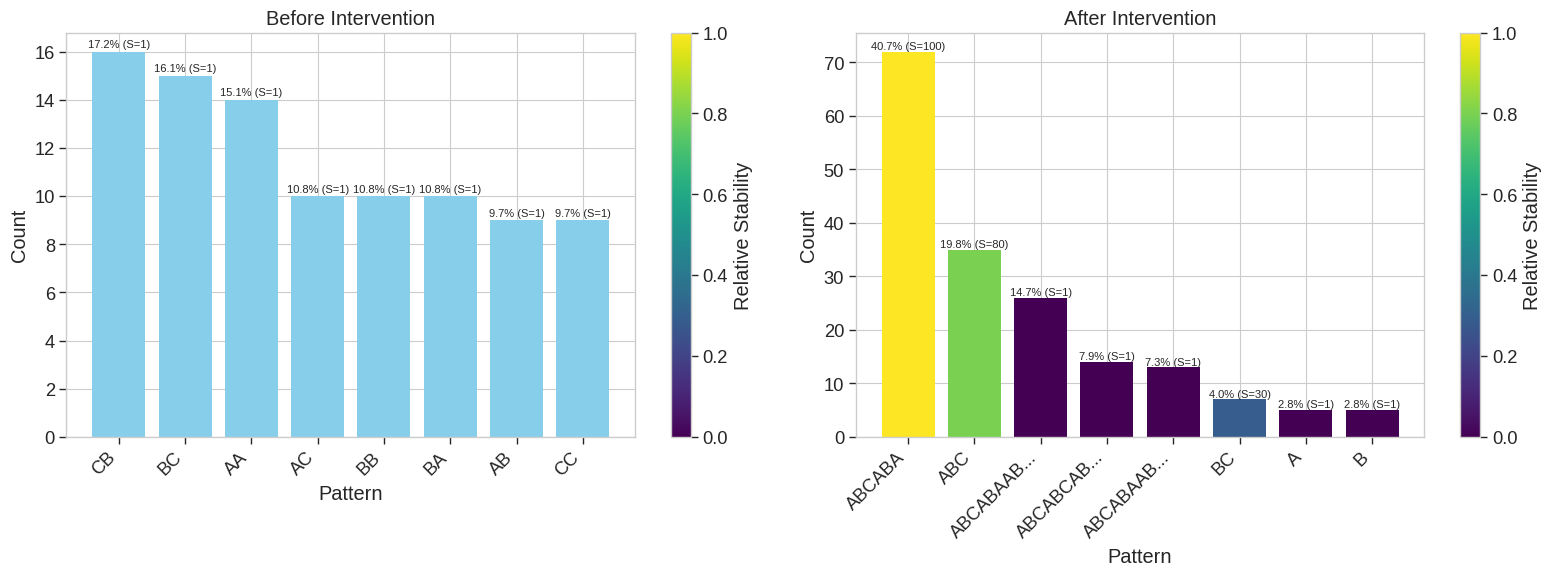


Intervention Metrics:
Entropy before: 3.4700
Entropy after: 4.8948
Entropy change: 1.4248
Pattern count before: 12.0
Pattern count after: 45.0
Pattern count change: 33.0
Running Custom to Uniform intervention experiment...
Phase 1: Before intervention (200 generations)


Custom Stability System:   0%|          | 0/200 [00:00<?, ?it/s]

Phase 2: After intervention (200 generations)


Custom Stability System:   0%|          | 0/200 [00:00<?, ?it/s]

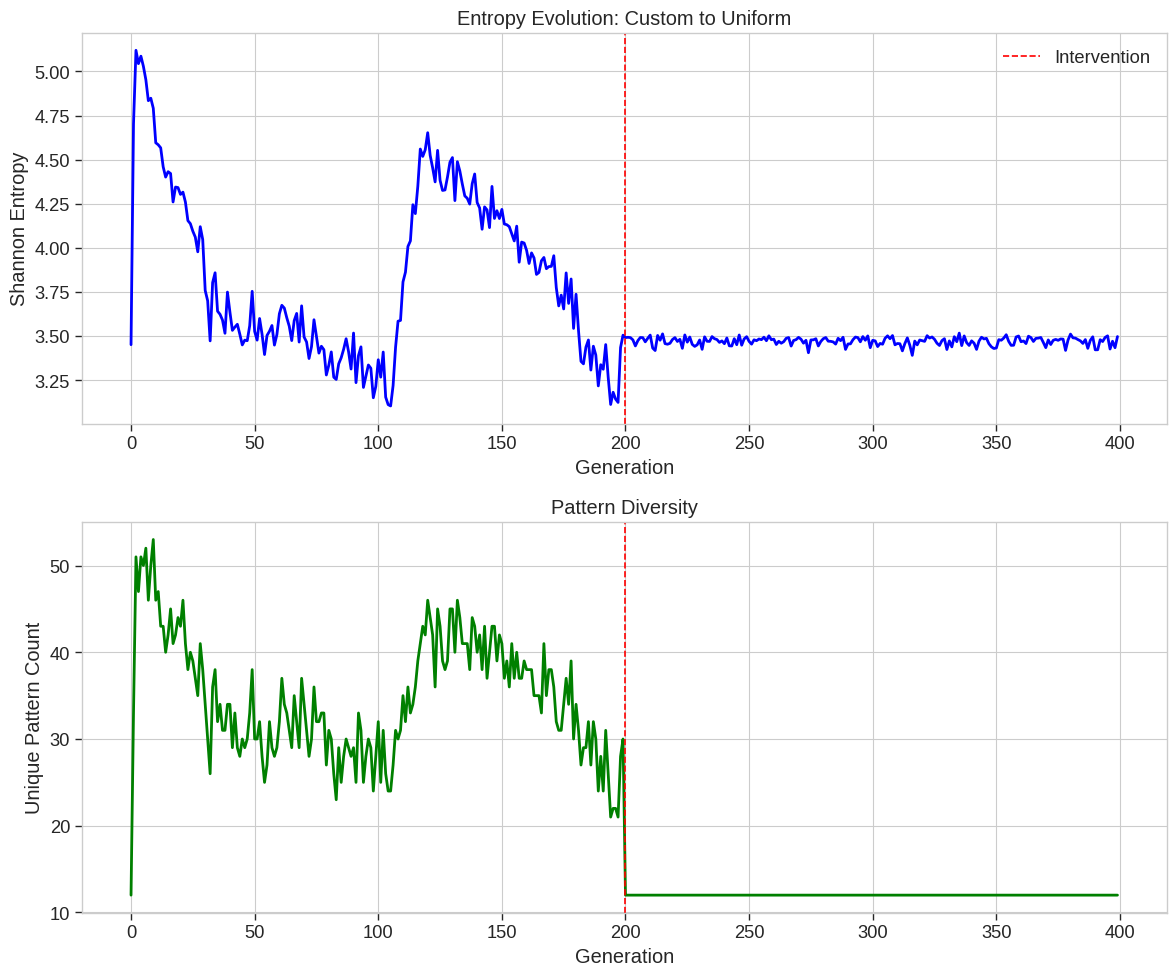

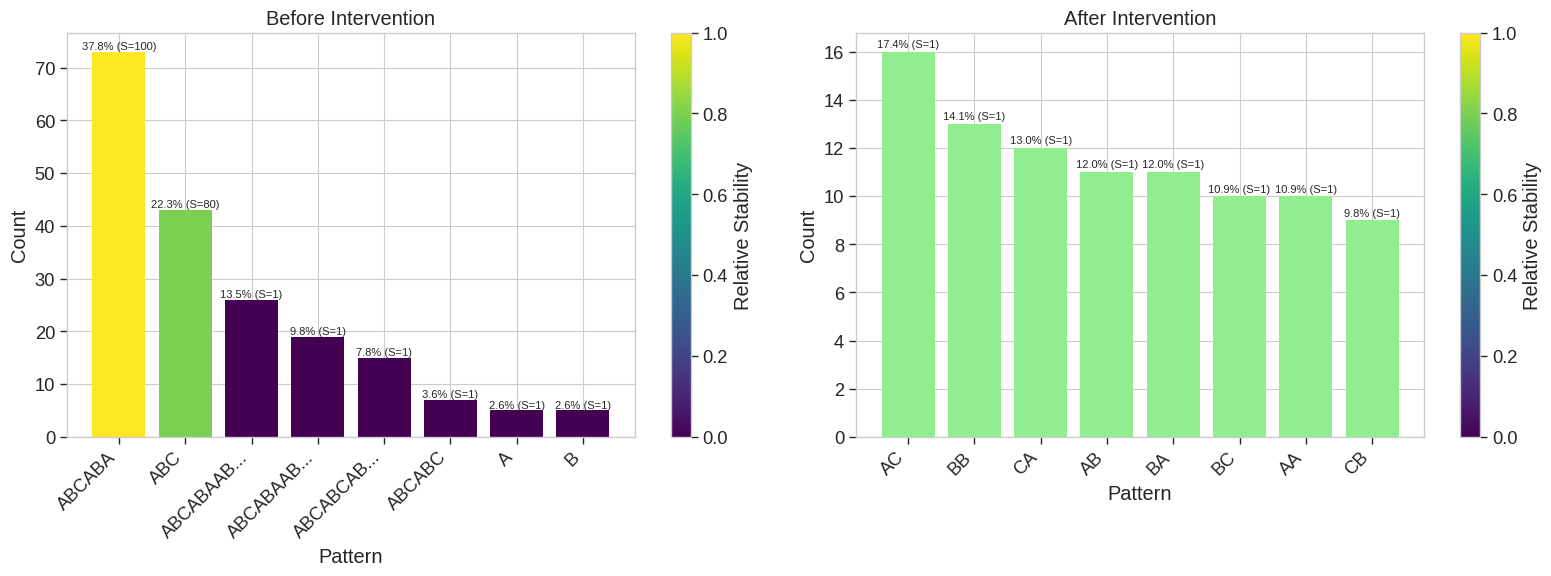


Intervention Metrics:
Entropy before: 3.2871
Entropy after: 3.4812
Entropy change: 0.1941
Pattern count before: 25.3
Pattern count after: 12.0
Pattern count change: -13.3


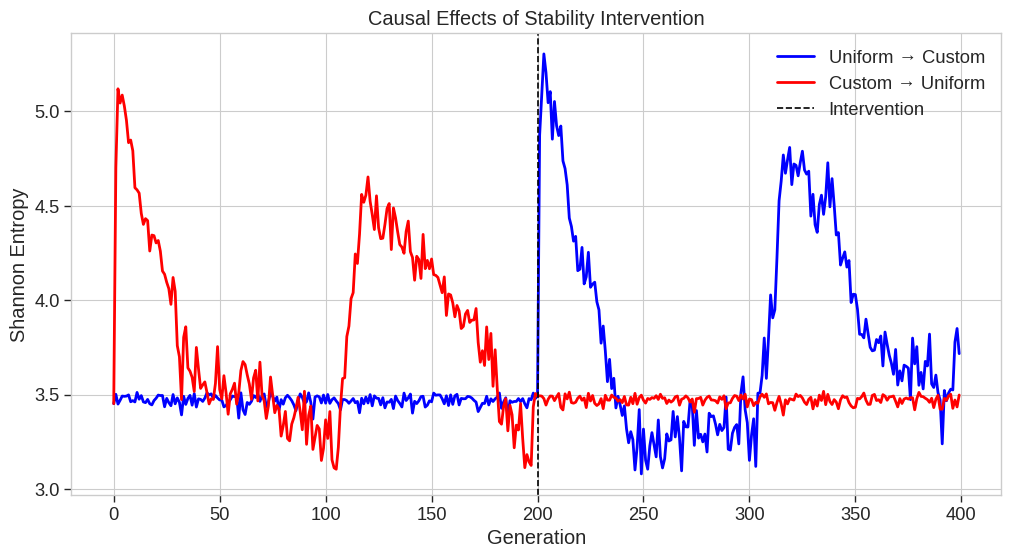

In [ ]:
# Custom Stability Intervention Experiment
# This code allows for custom stability dictionaries

import numpy as np
import matplotlib.pyplot as plt

# Function to run intervention experiment with custom stability dictionaries
def run_custom_intervention(
    base_elements=['A', 'B', 'C'],
    custom_stability=None,
    intervention_generation=100,
    experiment_type="custom_to_uniform",  # "uniform_to_custom" or "custom_to_uniform"
    generations=300,
    replenishment_rate=5,
    interactions_per_gen=100,
    seed=42
):
    """
    Run an intervention experiment using custom stability values.

    Parameters:
        base_elements: List of base element symbols
        custom_stability: Dictionary mapping patterns to stability values
        intervention_generation: Generation when intervention occurs
        experiment_type: "uniform_to_custom" or "custom_to_uniform"
        generations: Total number of generations to simulate
        replenishment_rate: Number of base elements added each generation
        interactions_per_gen: Number of interactions per generation
        seed: Random seed for reproducibility
    """
    # Create default custom stability if none provided
    if custom_stability is None:
        custom_stability = {
            "ABCABA": 100,  # First high stability pattern
            "ABC": 80,      # Second high stability pattern
            "AB": 15, "BC": 15, # Lower stability patterns
            "ABA": 15,
            "AC": 5,        # Low stability
            "A": 1, "B": 1, "C": 1  # Base elements
        }

    # Create uniform stability (all patterns have stability 1)
    uniform_stability = {element: 1 for element in base_elements}

    # Add any missing base elements to custom stability
    for element in base_elements:
        if element not in custom_stability:
            custom_stability[element] = 1

    # Set initial and final stability based on experiment type
    if experiment_type == "uniform_to_custom":
        initial_stability = uniform_stability
        final_stability = custom_stability
        title_prefix = "Uniform to Custom"
    else:  # "custom_to_uniform"
        initial_stability = custom_stability
        final_stability = uniform_stability
        title_prefix = "Custom to Uniform"

    print(f"Running {title_prefix} intervention experiment...")

    # Run first phase: Before intervention
    print(f"Phase 1: Before intervention ({intervention_generation} generations)")
    result1 = run_simulation(
        base_elements=base_elements,
        stability=initial_stability,
        replenishment_rate=replenishment_rate,
        interactions_per_gen=interactions_per_gen,
        generations=intervention_generation,
        selection_mode="frequency_proportional",
        name=f"{title_prefix} (Pre-Intervention)",
        seed=seed
    )

    # Store pre-intervention history
    pre_intervention_entropy = result1['history']['entropy'].copy()
    pre_intervention_patterns = result1['history']['pattern_counts'].copy()

    # Get final population for visualization
    if result1['history']['populations']:
        pre_intervention_population = result1['history']['populations'][-1]
    else:
        pre_intervention_population = {}

    # Run second phase: After intervention
    print(f"Phase 2: After intervention ({generations - intervention_generation} generations)")
    result2 = run_simulation(
        base_elements=base_elements,
        stability=final_stability,
        replenishment_rate=replenishment_rate,
        interactions_per_gen=interactions_per_gen,
        generations=generations - intervention_generation,
        selection_mode="frequency_proportional",
        name=f"{title_prefix} (Post-Intervention)",
        seed=seed + 1  # Use different seed to ensure variation
    )

    # Store post-intervention history
    post_intervention_entropy = result2['history']['entropy'].copy()
    post_intervention_patterns = result2['history']['pattern_counts'].copy()

    # Get final population for visualization
    if result2['history']['populations']:
        post_intervention_population = result2['history']['populations'][-1]
    else:
        post_intervention_population = {}

    # Combine results
    combined_entropy = pre_intervention_entropy + post_intervention_entropy
    combined_patterns = pre_intervention_patterns + post_intervention_patterns

    # Create visualization
    plt.figure(figsize=(12, 10))

    # Entropy plot
    plt.subplot(2, 1, 1)
    plt.plot(combined_entropy, 'b-', linewidth=2)
    plt.axvline(x=intervention_generation, color='r', linestyle='--', label='Intervention')
    plt.xlabel('Generation')
    plt.ylabel('Shannon Entropy')
    plt.title(f'Entropy Evolution: {title_prefix}')
    plt.legend()
    plt.grid(True)

    # Pattern count plot
    plt.subplot(2, 1, 2)
    plt.plot(combined_patterns, 'g-', linewidth=2)
    plt.axvline(x=intervention_generation, color='r', linestyle='--')
    plt.xlabel('Generation')
    plt.ylabel('Unique Pattern Count')
    plt.title('Pattern Diversity')
    plt.grid(True)

    plt.tight_layout()
    filename = experiment_type.replace('_', '-')
    plt.savefig(f'{filename}_intervention.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Compare pre and post intervention populations
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Pre-intervention
    if pre_intervention_population:
        pre_top = sorted(pre_intervention_population.items(), key=lambda x: x[1], reverse=True)[:8]
        if pre_top:
            patterns_pre, counts_pre = zip(*pre_top)
            display_pre = [p[:8] + ('...' if len(p) > 8 else '') for p in patterns_pre]

            # Get stability values for color mapping
            stabilities_pre = [initial_stability.get(p, 1) for p in patterns_pre]
            max_stab_pre = max(stabilities_pre)
            min_stab_pre = min(stabilities_pre)

            # Normalize for colormap (if there's variation)
            if max_stab_pre > min_stab_pre:
                norm_stab_pre = [(s - min_stab_pre) / (max_stab_pre - min_stab_pre) for s in stabilities_pre]
                bar_colors_pre = plt.cm.viridis(norm_stab_pre)
            else:
                bar_colors_pre = 'skyblue'

            bars_pre = axs[0].bar(range(len(display_pre)), counts_pre, color=bar_colors_pre)
            axs[0].set_xticks(range(len(display_pre)))
            axs[0].set_xticklabels(display_pre, rotation=45, ha='right')

            # Add percentage and stability labels
            total_pre = sum(counts_pre)
            for i, bar in enumerate(bars_pre):
                height = bar.get_height()
                percentage = (counts_pre[i] / total_pre * 100) if total_pre > 0 else 0
                stability = initial_stability.get(patterns_pre[i], 1)
                axs[0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                         f"{percentage:.1f}% (S={stability})", ha='center', va='bottom', rotation=0, fontsize=8)

    axs[0].set_xlabel('Pattern')
    axs[0].set_ylabel('Count')
    axs[0].set_title('Before Intervention')

    # Add colorbar for stability
    if pre_intervention_population:
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axs[0])
        cbar.set_label('Relative Stability')

    # Post-intervention
    if post_intervention_population:
        post_top = sorted(post_intervention_population.items(), key=lambda x: x[1], reverse=True)[:8]
        if post_top:
            patterns_post, counts_post = zip(*post_top)
            display_post = [p[:8] + ('...' if len(p) > 8 else '') for p in patterns_post]

            # Get stability values for color mapping
            stabilities_post = [final_stability.get(p, 1) for p in patterns_post]
            max_stab_post = max(stabilities_post)
            min_stab_post = min(stabilities_post)

            # Normalize for colormap (if there's variation)
            if max_stab_post > min_stab_post:
                norm_stab_post = [(s - min_stab_post) / (max_stab_post - min_stab_post) for s in stabilities_post]
                bar_colors_post = plt.cm.viridis(norm_stab_post)
            else:
                bar_colors_post = 'lightgreen'

            bars_post = axs[1].bar(range(len(display_post)), counts_post, color=bar_colors_post)
            axs[1].set_xticks(range(len(display_post)))
            axs[1].set_xticklabels(display_post, rotation=45, ha='right')

            # Add percentage and stability labels
            total_post = sum(counts_post)
            for i, bar in enumerate(bars_post):
                height = bar.get_height()
                percentage = (counts_post[i] / total_post * 100) if total_post > 0 else 0
                stability = final_stability.get(patterns_post[i], 1)
                axs[1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                          f"{percentage:.1f}% (S={stability})", ha='center', va='bottom', rotation=0, fontsize=8)

    axs[1].set_xlabel('Pattern')
    axs[1].set_ylabel('Count')
    axs[1].set_title('After Intervention')

    # Add colorbar for stability
    if post_intervention_population:
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axs[1])
        cbar.set_label('Relative Stability')

    plt.tight_layout()
    plt.savefig(f'{filename}_pattern_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate metrics
    pre_entropy_avg = np.mean(pre_intervention_entropy[-10:]) if pre_intervention_entropy else 0
    post_entropy_avg = np.mean(post_intervention_entropy[:10]) if post_intervention_entropy else 0
    entropy_change = post_entropy_avg - pre_entropy_avg

    pre_patterns_avg = np.mean(pre_intervention_patterns[-10:]) if pre_intervention_patterns else 0
    post_patterns_avg = np.mean(post_intervention_patterns[:10]) if post_intervention_patterns else 0
    patterns_change = post_patterns_avg - pre_patterns_avg

    print(f"\nIntervention Metrics:")
    print(f"Entropy before: {pre_entropy_avg:.4f}")
    print(f"Entropy after: {post_entropy_avg:.4f}")
    print(f"Entropy change: {entropy_change:.4f}")
    print(f"Pattern count before: {pre_patterns_avg:.1f}")
    print(f"Pattern count after: {post_patterns_avg:.1f}")
    print(f"Pattern count change: {patterns_change:.1f}")

    return {
        'type': experiment_type,
        'entropy': combined_entropy,
        'pattern_counts': combined_patterns,
        'intervention_generation': intervention_generation,
        'pre_population': pre_intervention_population,
        'post_population': post_intervention_population,
        'initial_stability': initial_stability,
        'final_stability': final_stability,
        'metrics': {
            'pre_entropy': pre_entropy_avg,
            'post_entropy': post_entropy_avg,
            'entropy_change': entropy_change,
            'pre_patterns': pre_patterns_avg,
            'post_patterns': post_patterns_avg,
            'patterns_change': patterns_change
        }
    }

# Run both types of custom intervention experiments
def run_both_custom_interventions(
    base_elements=['A', 'B', 'C'],
    custom_stability=None,
    intervention_generation=100,
    generations=300,
    replenishment_rate=5,
    interactions_per_gen=100
):
    """Run both types of custom intervention experiments and create comparative visualization."""
    # Default custom stability if none provided
    if custom_stability is None:
        custom_stability = {
            "ABCABA": 100,  # First high stability pattern
            "ABC": 80,      # Second high stability pattern
            "AB": 15, "BC": 15, # Lower stability patterns
            "ABA": 15,
            "AC": 5,        # Low stability
            "A": 1, "B": 1, "C": 1  # Base elements
        }

    # Uniform to Custom
    uniform_to_custom = run_custom_intervention(
        base_elements=base_elements,
        custom_stability=custom_stability,
        intervention_generation=intervention_generation,
        experiment_type="uniform_to_custom",
        generations=generations,
        replenishment_rate=replenishment_rate,
        interactions_per_gen=interactions_per_gen
    )

    # Custom to Uniform
    custom_to_uniform = run_custom_intervention(
        base_elements=base_elements,
        custom_stability=custom_stability,
        intervention_generation=intervention_generation,
        experiment_type="custom_to_uniform",
        generations=generations,
        replenishment_rate=replenishment_rate,
        interactions_per_gen=interactions_per_gen
    )

    # Create combined visualization
    plt.figure(figsize=(12, 6))

    # Plot both entropy curves
    plt.plot(uniform_to_custom['entropy'], 'b-', label="Uniform → Custom", linewidth=2)
    plt.plot(custom_to_uniform['entropy'], 'r-', label="Custom → Uniform", linewidth=2)
    plt.axvline(x=intervention_generation, color='k', linestyle='--', label='Intervention')

    plt.xlabel('Generation')
    plt.ylabel('Shannon Entropy')
    plt.title('Causal Effects of Stability Intervention')
    plt.legend()
    plt.grid(True)

    plt.savefig('combined_custom_interventions.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'uniform_to_custom': uniform_to_custom,
        'custom_to_uniform': custom_to_uniform
    }

# Example usage
if __name__ == "__main__":
    # Define custom stability dictionary
    custom_stability = {
        "ABCABA": 100,  # First high stability pattern
        "ABC": 80,      # Second high stability pattern
        "AB": 30, "BC": 30, # Lower stability patterns
        "ABA": 15,
        "AC": 5,        # Low stability
        "A": 1, "B": 1, "C": 1  # Base elements
    }

    # Run both intervention types
    results = run_both_custom_interventions(
        base_elements=['A', 'B', 'C'],
        custom_stability=custom_stability,
        intervention_generation=200,
        generations=400,
        replenishment_rate=5,
        interactions_per_gen=100
    )

Running unconstrained simulation...


Unconstrained System:   0%|          | 0/200 [00:00<?, ?it/s]


Running custom stability simulation...


Custom Stability System:   0%|          | 0/200 [00:00<?, ?it/s]


Key Metrics:
Final entropy (Unconstrained): 6.2165
Final entropy (Custom Stability): 6.0244
Entropy reduction: 0.1920

Top patterns in Unconstrained system:
  A: 5 (4.35%)
  B: 5 (4.35%)
  C: 5 (4.35%)
  BB: 4 (3.48%)
  BC: 4 (3.48%)

Top patterns in Custom Stability system:
  ABCABA: 77 (22.85%)
  ABA: 12 (3.56%)
  ABC: 11 (3.26%)
  A: 10 (2.97%)
  B: 10 (2.97%)


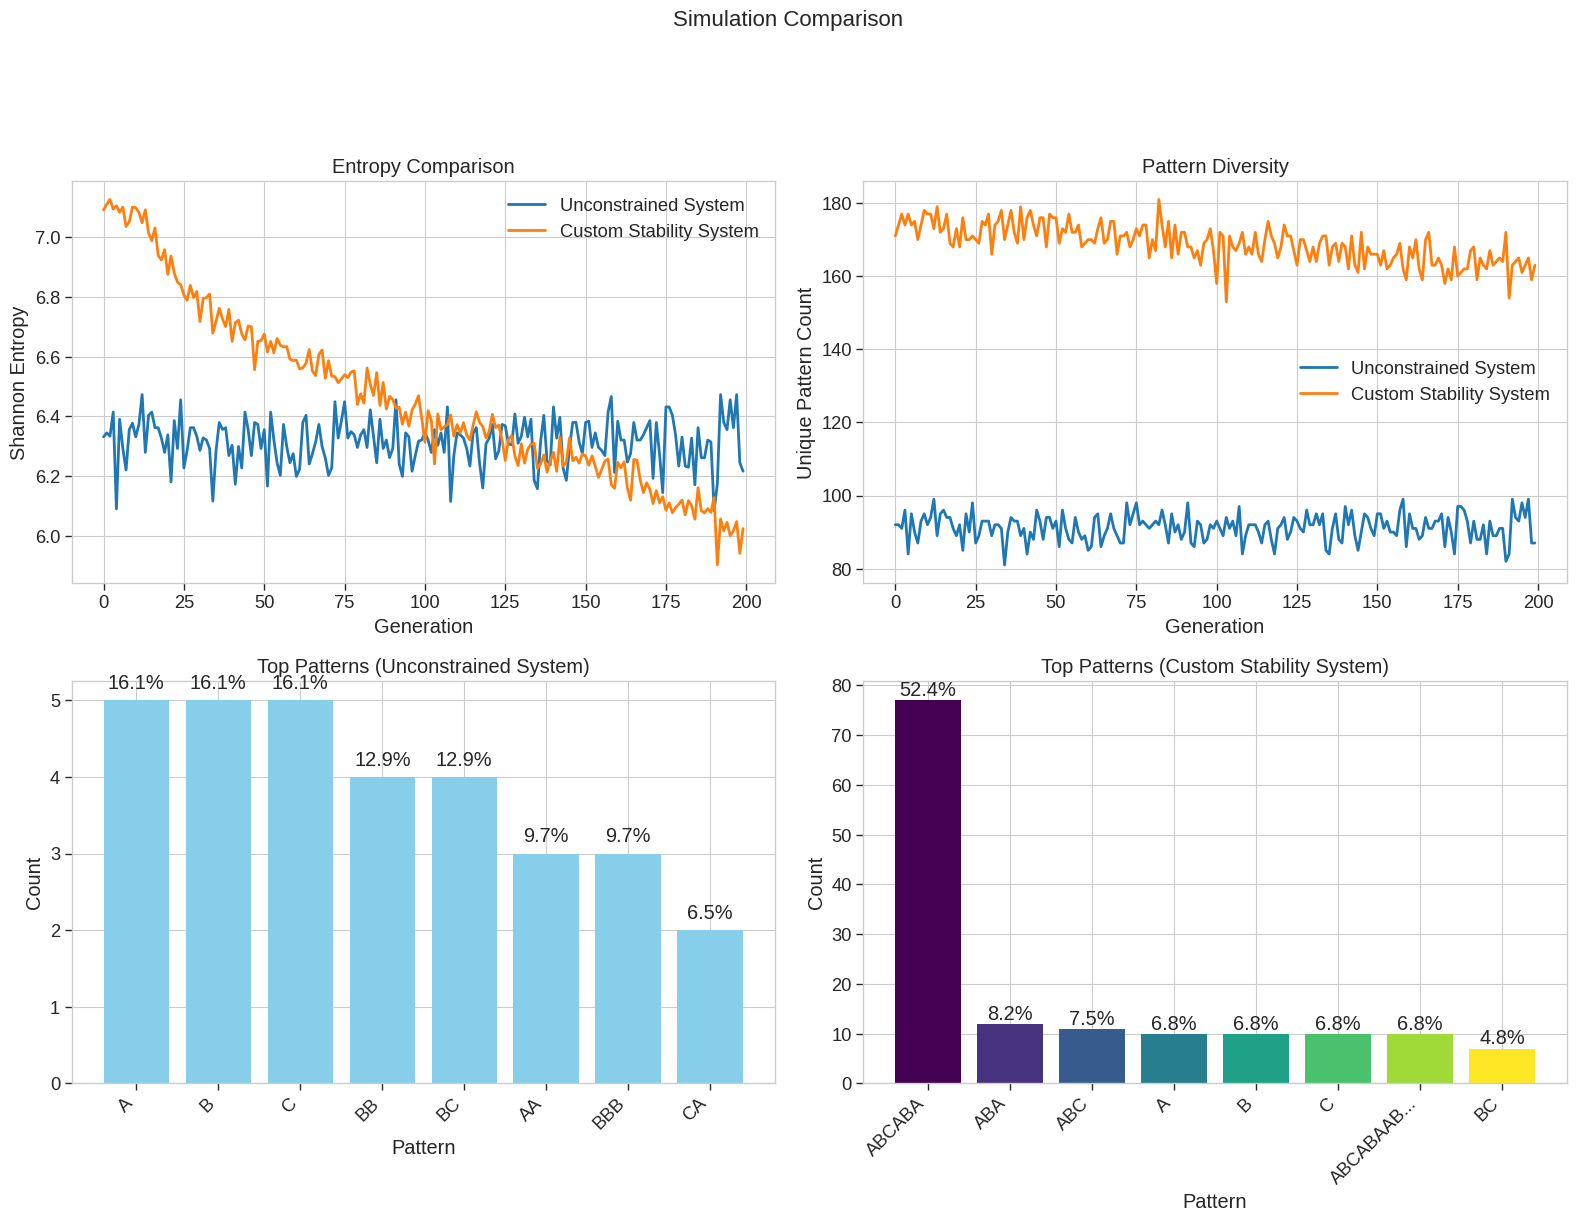

In [ ]:
# Intervention experiment

custom_stability = {
    "AB": 30, "BC": 30, "ABC": 30, "ABA": 50, "ABCABA": 200,  # High stability for specific compounds
    "AC": 10, "A": 1, "B": 1, "C": 1  # Lower stability for others
}

replenishment_rate = 5
interactions_per_gen=100
generations=200

# Run both simulations
print("Running unconstrained simulation...")
unconstrained_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # No specific stability values
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="uniform",  # Random selection
    seed=42
)

print("\nRunning custom stability simulation...")
custom_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=custom_stability,
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="frequency_proportional",  # Selection based on pattern frequency
    init_pop=unconstrained_result['final_raw_population'],  # Initialize with unconstrained raw population
    seed=42
)

# Create comparison figure
fig = compare_simulations([unconstrained_result, custom_result])

# Print key metrics
print("\nKey Metrics:")
print(f"Final entropy (Unconstrained): {unconstrained_result['history']['entropy'][-1]:.4f}")
print(f"Final entropy (Custom Stability): {custom_result['history']['entropy'][-1]:.4f}")
print(f"Entropy reduction: {unconstrained_result['history']['entropy'][-1] - custom_result['history']['entropy'][-1]:.4f}")

# Save the figure
fig.savefig('custom_stability_comparison.png', dpi=300, bbox_inches='tight')

# Print top patterns in each system
print("\nTop patterns in Unconstrained system:")
for pattern, count in sorted(unconstrained_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(unconstrained_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

print("\nTop patterns in Custom Stability system:")
for pattern, count in sorted(custom_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(custom_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

Running initial unconstrained simulation...


Unconstrained System:   0%|          | 0/400 [00:00<?, ?it/s]

Running initial SDA simulation...


Custom Stability System:   0%|          | 0/400 [00:00<?, ?it/s]


Running intervention: Unconstrained → SDA...


Custom Stability System:   0%|          | 0/400 [00:00<?, ?it/s]


Running intervention: SDA → Unconstrained...


Unconstrained System:   0%|          | 0/400 [00:00<?, ?it/s]

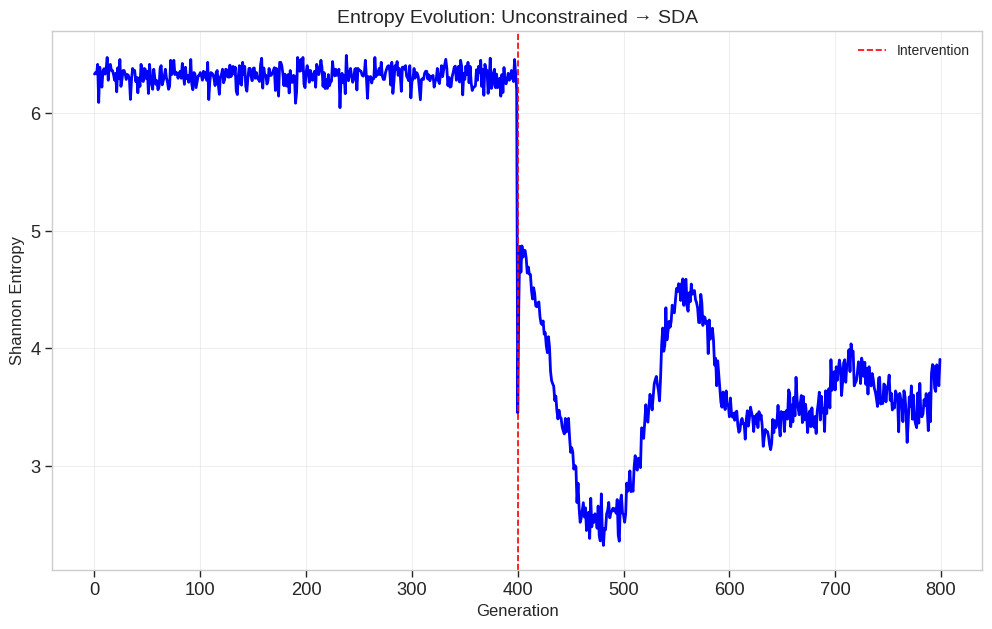

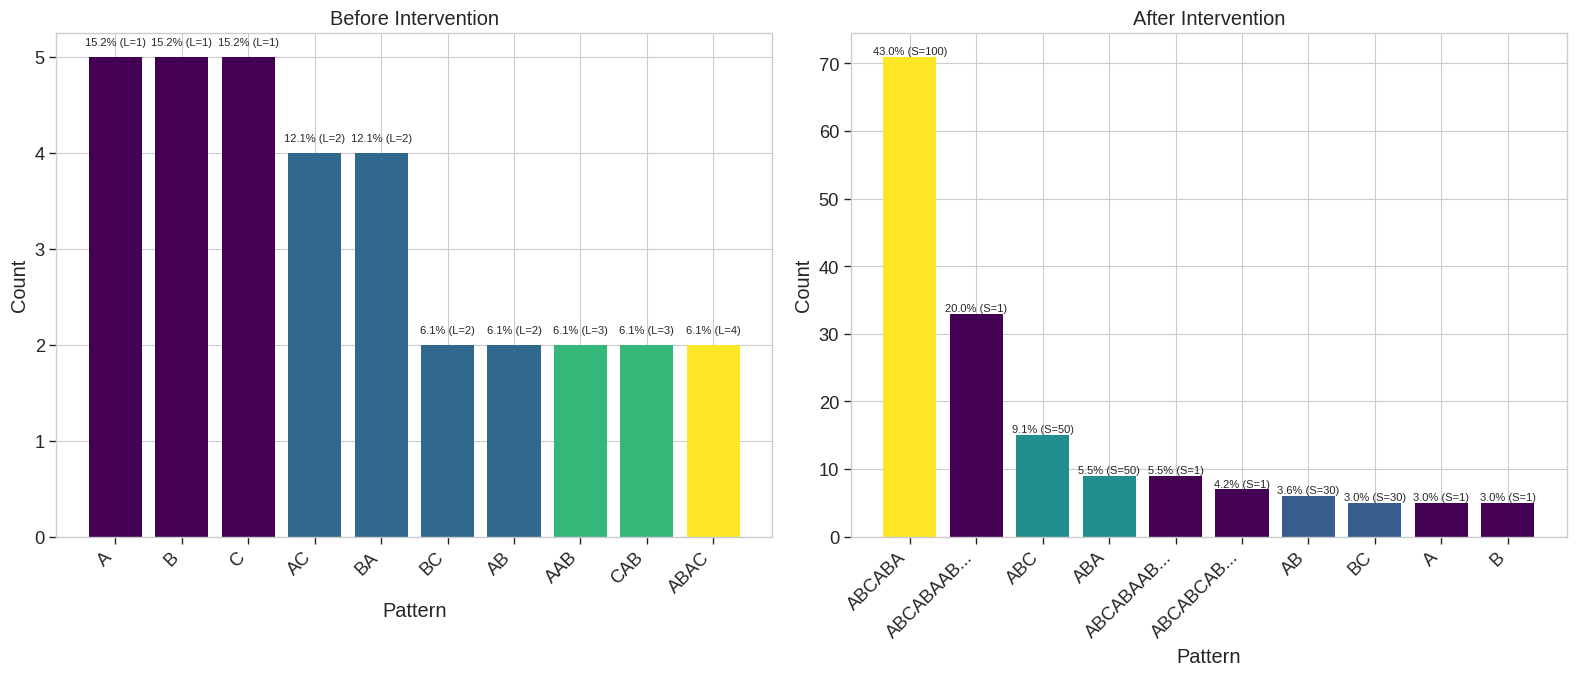


Unconstrained → SDA Intervention Metrics:
Pre-intervention entropy: 6.3145
Post-intervention entropy (immediate): 3.4514
Post-intervention entropy (early avg): 4.6055
Post-intervention entropy (final): 3.7394
Entropy change: -1.7090


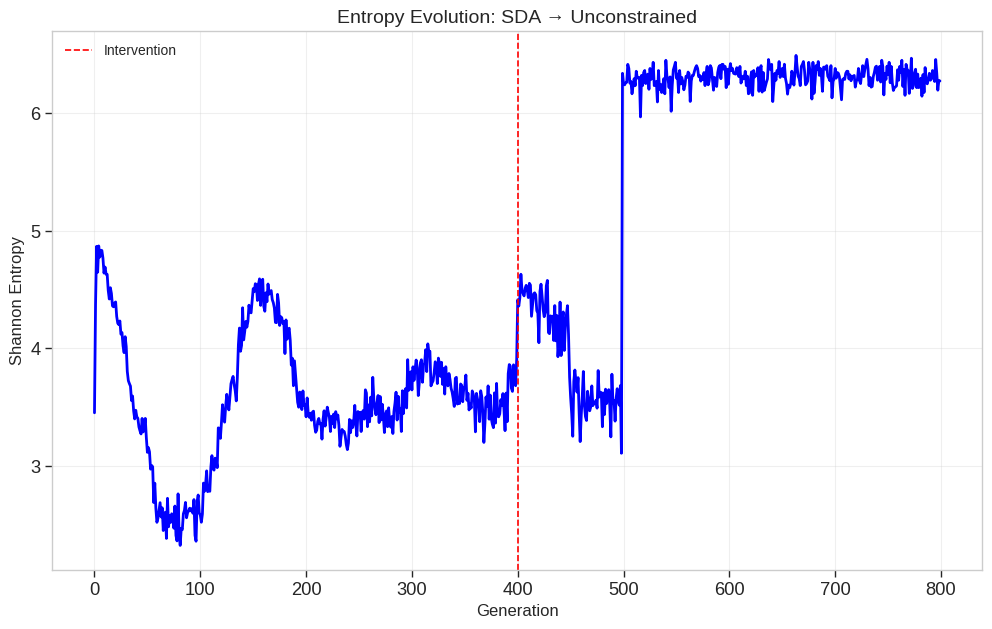

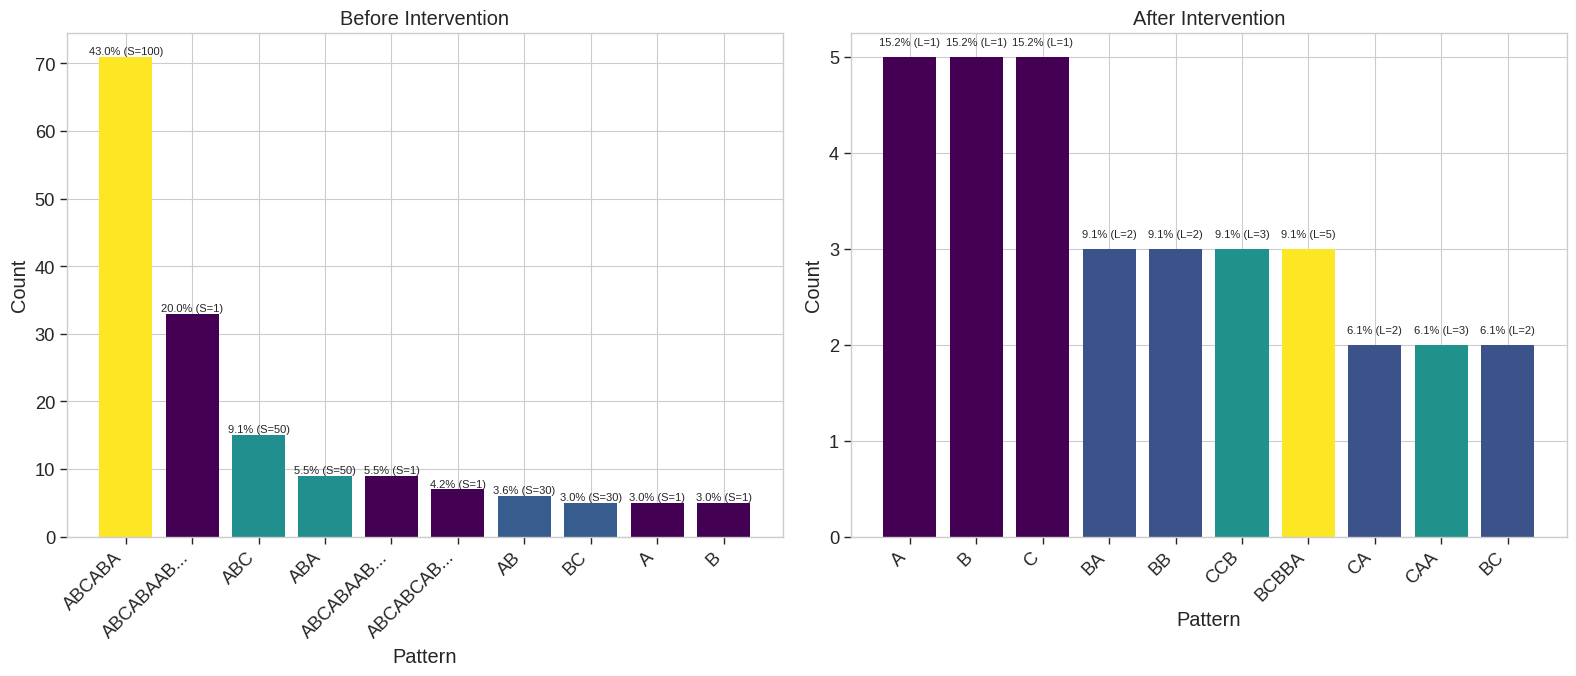


SDA → Unconstrained Intervention Metrics:
Pre-intervention entropy: 3.7394
Post-intervention entropy (immediate): 4.4125
Post-intervention entropy (early avg): 4.4782
Post-intervention entropy (final): 6.3072
Entropy change: 0.7389


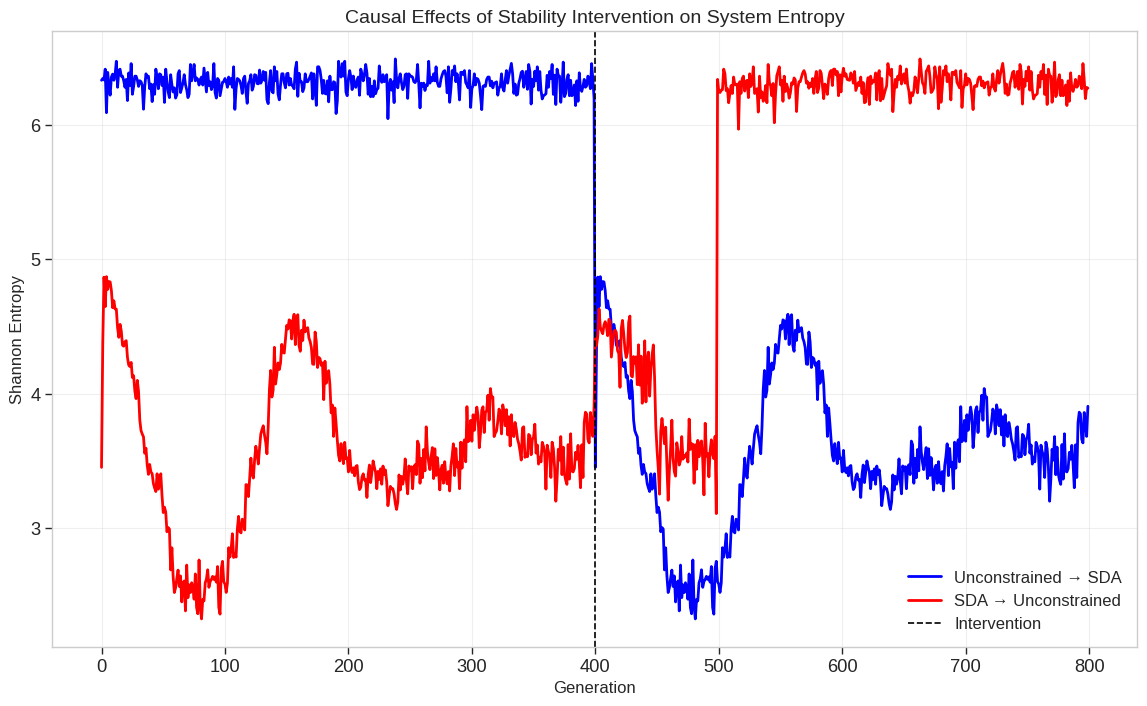


Key SDA System Findings:
1. When switching from unconstrained to SDA:
   - Entropy changed by -2.8631 bits
   - High-stability patterns (ABC, ABA, ABCABA) become dominant

2. When switching from SDA to unconstrained:
   - Entropy changed by 0.6732 bits
   - Pattern diversity increases as stability constraints are removed

Conclusions:
- Stability-driven selection reduces entropy and focuses the system on high-stability patterns
- The SDA system demonstrates emergence of dominant patterns through natural selection
- Pattern distribution follows a peaked distribution in SDA vs. broader distribution in unconstrained systems
- These findings support the theoretical predictions of Stability-Driven Assembly Theory


In [ ]:
# Define custom stability dictionary
custom_stability = {
    "AB": 30, "BC": 30, "ABC": 50,
    "ABA": 50, "ABCABA": 100,  # High stability for specific compounds
    "A": 1, "B": 1, "C": 1  # Lower stability for others
}

replenishment_rate = 5
interactions_per_gen = 100
generations = 400

# Run initial simulation for each type
print("Running initial unconstrained simulation...")
unconstrained_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # No specific stability values
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="uniform",  # Selection is uniform
    init_pop=None,  # Initialize with unconstrained population
    seed=42
)

print("Running initial SDA simulation...")
sda_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=custom_stability,
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="frequency_proportional",  # Selection based on frequency
    init_pop=None,  # Initialize with unconstrained population
    seed=42
)

# Intervention 1: Unconstrained to SDA
print("\nRunning intervention: Unconstrained → SDA...")
u2s_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=custom_stability,
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="frequency_proportional",
    init_pop=unconstrained_result['final_raw_population'],  # Initialize with unconstrained population
    seed=42
)

# Intervention 2: SDA to Unconstrained
print("\nRunning intervention: SDA → Unconstrained...")
s2u_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # No specific stability values
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="uniform",
    init_pop=sda_result['final_raw_population'],  # Initialize with SDA population
    seed=42
)

# Process and visualize results
results = {
    "unconstrained_to_sda": {
        "pre_result": unconstrained_result,
        "post_result": u2s_result,
        "name": "Unconstrained → SDA",
        "sda_stability_dict": custom_stability
    },
    "sda_to_unconstrained": {
        "pre_result": sda_result,
        "post_result": s2u_result,
        "name": "SDA → Unconstrained",
        "sda_stability_dict": custom_stability
    }
}

# Process results
for exp_type, result_data in results.items():
    pre_result = result_data["pre_result"]
    post_result = result_data["post_result"]

    # Combine entropy data
    combined_entropy = pre_result['history']['entropy'] + post_result['history']['entropy']
    intervention_gen = len(pre_result['history']['entropy'])

    # Create entropy visualization
    plt.figure(figsize=(12, 7))
    plt.plot(combined_entropy, 'b-', linewidth=2)
    plt.axvline(x=intervention_gen, color='r', linestyle='--', label='Intervention')
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Shannon Entropy', fontsize=12)
    plt.title(f'Entropy Evolution: {result_data["name"]}', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{exp_type}_entropy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate metrics
    pre_entropy_avg = np.mean(pre_result['history']['entropy'][-10:])
    post_entropy_first = post_result['history']['entropy'][0]
    post_entropy_avg = np.mean(post_result['history']['entropy'][:10])
    post_entropy_final = np.mean(post_result['history']['entropy'][-10:])

    entropy_change = post_entropy_avg - pre_entropy_avg

    # Pre vs Post population comparison
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))

    # Pre-intervention population
    pre_pop = pre_result['final_population']
    pre_top = sorted(pre_pop.items(), key=lambda x: x[1], reverse=True)[:10]
    if pre_top:
        patterns_pre, counts_pre = zip(*pre_top)
        display_pre = [p[:8] + ('...' if len(p) > 8 else '') for p in patterns_pre]

        # Get stability values for color mapping
        if exp_type == "sda_to_unconstrained":
            # Use stability for coloring
            stabilities_pre = [custom_stability.get(p, 1) for p in patterns_pre]
            color_label = "Stability"
        else:
            # Use pattern length for coloring
            stabilities_pre = [len(p) for p in patterns_pre]
            color_label = "Length"

        # Normalize colors
        max_val = max(stabilities_pre)
        min_val = min(stabilities_pre)
        if max_val > min_val:
            norm_vals = [(s - min_val) / (max_val - min_val) for s in stabilities_pre]
            bar_colors = plt.cm.viridis(norm_vals)
        else:
            bar_colors = 'skyblue'

        bars_pre = axs[0].bar(range(len(display_pre)), counts_pre, color=bar_colors)
        axs[0].set_xticks(range(len(display_pre)))
        axs[0].set_xticklabels(display_pre, rotation=45, ha='right')

        # Add percentage and value labels
        total_pre = sum(counts_pre)
        for i, bar in enumerate(bars_pre):
            height = bar.get_height()
            percentage = (counts_pre[i] / total_pre * 100) if total_pre > 0 else 0
            val = stabilities_pre[i]
            axs[0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f"{percentage:.1f}% ({color_label[0]}={val})", ha='center', va='bottom', rotation=0, fontsize=8)

    axs[0].set_xlabel('Pattern')
    axs[0].set_ylabel('Count')
    axs[0].set_title(f'Before Intervention')

    # Post-intervention population
    post_pop = post_result['final_population']
    post_top = sorted(post_pop.items(), key=lambda x: x[1], reverse=True)[:10]
    if post_top:
        patterns_post, counts_post = zip(*post_top)
        display_post = [p[:8] + ('...' if len(p) > 8 else '') for p in patterns_post]

        # Get values for color mapping
        if exp_type == "unconstrained_to_sda":
            # Use stability for coloring
            values_post = [custom_stability.get(p, 1) for p in patterns_post]
            color_label = "Stability"
        else:
            # Use pattern length for coloring
            values_post = [len(p) for p in patterns_post]
            color_label = "Length"

        # Normalize colors
        max_val = max(values_post)
        min_val = min(values_post)
        if max_val > min_val:
            norm_vals = [(s - min_val) / (max_val - min_val) for s in values_post]
            bar_colors = plt.cm.viridis(norm_vals)
        else:
            bar_colors = 'lightgreen'

        bars_post = axs[1].bar(range(len(display_post)), counts_post, color=bar_colors)
        axs[1].set_xticks(range(len(display_post)))
        axs[1].set_xticklabels(display_post, rotation=45, ha='right')

        # Add percentage and value labels
        total_post = sum(counts_post)
        for i, bar in enumerate(bars_post):
            height = bar.get_height()
            percentage = (counts_post[i] / total_post * 100) if total_post > 0 else 0
            val = values_post[i]
            axs[1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                      f"{percentage:.1f}% ({color_label[0]}={val})", ha='center', va='bottom', rotation=0, fontsize=8)

    axs[1].set_xlabel('Pattern')
    axs[1].set_ylabel('Count')
    axs[1].set_title(f'After Intervention')

    plt.tight_layout()
    plt.savefig(f'{exp_type}_population_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print metrics
    print(f"\n{result_data['name']} Intervention Metrics:")
    print(f"Pre-intervention entropy: {pre_entropy_avg:.4f}")
    print(f"Post-intervention entropy (immediate): {post_entropy_first:.4f}")
    print(f"Post-intervention entropy (early avg): {post_entropy_avg:.4f}")
    print(f"Post-intervention entropy (final): {post_entropy_final:.4f}")
    print(f"Entropy change: {entropy_change:.4f}")

# Combined visualization
plt.figure(figsize=(14, 8))

# Get data
u2s_entropy = results["unconstrained_to_sda"]["pre_result"]["history"]["entropy"] + results["unconstrained_to_sda"]["post_result"]["history"]["entropy"]
s2u_entropy = results["sda_to_unconstrained"]["pre_result"]["history"]["entropy"] + results["sda_to_unconstrained"]["post_result"]["history"]["entropy"]
intervention_gen = len(results["unconstrained_to_sda"]["pre_result"]["history"]["entropy"])

# Plot
plt.plot(u2s_entropy, 'b-', label="Unconstrained → SDA", linewidth=2)
plt.plot(s2u_entropy, 'r-', label="SDA → Unconstrained", linewidth=2)
plt.axvline(x=intervention_gen, color='k', linestyle='--', label='Intervention')

plt.xlabel('Generation', fontsize=12)
plt.ylabel('Shannon Entropy', fontsize=12)
plt.title('Causal Effects of Stability Intervention on System Entropy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.savefig('combined_interventions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary findings
print("\nKey SDA System Findings:")
u2s_change = results["unconstrained_to_sda"]["post_result"]["history"]["entropy"][0] - np.mean(results["unconstrained_to_sda"]["pre_result"]["history"]["entropy"][-10:])
s2u_change = results["sda_to_unconstrained"]["post_result"]["history"]["entropy"][0] - np.mean(results["sda_to_unconstrained"]["pre_result"]["history"]["entropy"][-10:])

print(f"1. When switching from unconstrained to SDA:")
print(f"   - Entropy changed by {u2s_change:.4f} bits")
print(f"   - High-stability patterns ({', '.join([k for k,v in custom_stability.items() if v > 30])}) become dominant")

print(f"\n2. When switching from SDA to unconstrained:")
print(f"   - Entropy changed by {s2u_change:.4f} bits")
print(f"   - Pattern diversity increases as stability constraints are removed")

print("\nConclusions:")
print("- Stability-driven selection reduces entropy and focuses the system on high-stability patterns")
print("- The SDA system demonstrates emergence of dominant patterns through natural selection")
print("- Pattern distribution follows a peaked distribution in SDA vs. broader distribution in unconstrained systems")
print("- These findings support the theoretical predictions of Stability-Driven Assembly Theory")